In [ ]:
import pandas as pd
### pval <= 5e-8
gwas_results = pd.read_csv("/oak/stanford/groups/akundaje/ziwei75/ALS_colab/sod1_project/vanRheene_2021_summary_stats_hg38.csv")
significant_gwas_loci = gwas_results[gwas_results['neg_log_pvalue'] > 7.3]

In [ ]:
significant_gwas_loci

In [2]:
significant_gwas_loci.to_csv("/oak/stanford/groups/akundaje/ziwei75/ALS_colab/sod1_project/vanRheene_2021_summary_significant_variants.csv",\
                            sep="\t",\
                            index=False)

In [34]:
import pyfaidx
genome = pyfaidx.Fasta("/oak/stanford/groups/akundaje/ziwei75/atac_seq_pipeline/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta")


In [35]:
from tqdm import tqdm
for i, row in tqdm(significant_gwas_loci.iterrows()):
    chromo = row['chr']
    pos = row['start'] - 1
    ref = row['ref']
    alt = row['alt']
    try:
        assert genome[chromo][pos].seq == ref or genome[chromo][pos].seq == alt
    except:
        print(row)

483it [00:00, 9659.55it/s]


In [13]:
significant_gwas_loci = significant_gwas_loci[['chr','start','rsid','ref','alt']]

In [20]:
significant_gwas_loci.to_csv("/oak/stanford/groups/akundaje/ziwei75/ALS_colab/sod1_project/vanRheene_2021_summary_significant_variants.tsv",\
                           header=None,\
                           index=False,\
                           sep="\t")

In [26]:
significant_gwas_loci_bed = []
for i,row in significant_gwas_loci.iterrows():
    chromo, start, rsid, ref, alt = row.values
    end = start + 1
    significant_gwas_loci_bed += [[chromo, start,end,rsid,ref,alt]]

In [28]:
significant_gwas_loci_bed = pd.DataFrame(significant_gwas_loci_bed)
significant_gwas_loci_bed.to_csv("/oak/stanford/groups/akundaje/ziwei75/ALS_colab/sod1_project/vanRheene_2021_summary_significant_variants.bed",\
                           header=None,\
                           index=False,\
                                sep="\t")

### plot variant scores
bedtools cluster -i vanRheene_2021_summary_significant_variants.bed -d 100000 > vanRheene_2021_summary_significant_variants_with_clusters.bed

In [5]:
### load cluster info
import pandas as pd
gwas_results = pd.read_csv("/oak/stanford/groups/akundaje/ziwei75/ALS_colab/sod1_project/vanRheene_2021_summary_stats_hg38.csv")
signifincat_with_cluster = pd.read_csv("/oak/stanford/groups/akundaje/ziwei75/ALS_colab/sod1_project/vanRheene_2021_summary_significant_variants_with_clusters.bed",\
           sep="\t",\
           names=['chr','start','end','rsid' ,'ref','alt','cluster_num'])

In [6]:
cluster_position=[]
for cluster_num in range(1,14):
    cluster = signifincat_with_cluster[signifincat_with_cluster['cluster_num'] == cluster_num]
    pos_list = []
    for i, row in cluster.iterrows():
        pos = row['start']
        pos_list += [pos]
    chromo = row['chr']
    min_pos, max_pos = min(pos_list),max(pos_list)
    cluster_position += [[chromo, min_pos-100000,max_pos+100000]]

In [7]:
all_filtered_gwas_results = []
for i in range(len(cluster_position)):
    chromo, start, end = cluster_position[i]
    filtered_gwas_results = gwas_results[gwas_results['chr'] == chromo]
    filtered_gwas_results = filtered_gwas_results[filtered_gwas_results['start'] > start]
    filtered_gwas_results = filtered_gwas_results[filtered_gwas_results['end'] < end]
    filtered_gwas_results['cluster_num'] = i+1
    all_filtered_gwas_results += [filtered_gwas_results]

In [8]:
all_filtered_gwas_results=pd.concat(all_filtered_gwas_results)

In [79]:
all_filtered_gwas_results.to_csv("/oak/stanford/groups/akundaje/ziwei75/ALS_colab/sod1_project/vanRheene_2021_summary_significant_variants_include_all_and_annotation.tsv",\
                           header=None,\
                           index=False,\
                           sep="\t")

In [80]:
all_filtered_gwas_results_tsv = all_filtered_gwas_results[['chr','start','rsid','ref','alt']]
all_filtered_gwas_results_tsv.to_csv("/oak/stanford/groups/akundaje/ziwei75/ALS_colab/sod1_project/vanRheene_2021_summary_significant_variants_include_all.tsv",\
                           header=None,\
                           index=False,\
                           sep="\t")

In [11]:
variant_predictions = pd.read_csv("/oak/stanford/groups/akundaje/ziwei75/ALS_colab/output/variant_scoring/alpha_control/vanRheene_2021_summaray_significant.variant_scores.tsv",\
           sep="\t")
variant_predictions = variant_predictions[['variant_id','abs_logfc','jsd','jsd.pval','abs_logfc.pval']]
variant_predictions = variant_predictions.rename({"variant_id":"rsid"},axis=1)

In [12]:
all_filtered_gwas_results = all_filtered_gwas_results.merge(variant_predictions,on="rsid")


In [13]:
significant_variants_from_predictions = all_filtered_gwas_results[(all_filtered_gwas_results['jsd.pval'] < 0.05) | (all_filtered_gwas_results['abs_logfc.pval'] < 0.05)]
significant_variants_from_predictions = significant_variants_from_predictions[['chr','start','rsid','ref','alt']]

In [14]:
significant_variants_from_predictions.to_csv("/oak/stanford/groups/akundaje/ziwei75/ALS_colab/output/predicted_significant_variants_pval_0.05.tsv",\
                                            sep="\t",\
                                            header=None,
                                            index=False)




In [19]:
import h5py
import pandas as pd
significant_variants_from_predictions=pd.read_csv("/oak/stanford/groups/akundaje/ziwei75/ALS_colab/output/predicted_significant_variants_pval_0.05.tsv",\
                                                  sep='\t',\
                                                 header=None)
significant_variants_from_predictions.columns=['chr','start','rsid','ref','alt']
shap_scores = h5py.File("/oak/stanford/groups/akundaje/ziwei75/ALS_colab/output/variant_scoring/alpha_control/vanRheene_2021_summaray_significant_shap.variant_shap.counts.h5")
significant_variants_from_predictions = significant_variants_from_predictions.reset_index(drop=True)
allele1_shap=shap_scores['observed']['allele1_shap']
allele2_shap=shap_scores['observed']['allele2_shap']

import pyfaidx
from tqdm import tqdm
genome = pyfaidx.Fasta("/oak/stanford/groups/akundaje/ziwei75/atac_seq_pipeline/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta")
allele1_sequences = []
allele2_sequences = []
for i, row in tqdm(significant_variants_from_predictions.iterrows()):
    chromo = row['chr']
    pos = row['start'] - 1
    ref = row['ref']
    alt = row['alt']

    assert genome[chromo][pos].seq == ref or genome[chromo][pos].seq == alt
    left_flank = genome[chromo][pos-1057:pos].seq
    right_flank = genome[chromo][pos+1:pos+1057].seq
    allele1_sequences += [left_flank + ref + right_flank]
    allele2_sequences += [left_flank + alt + right_flank]
    
import sys
sys.path.append("/oak/stanford/groups/akundaje/ziwei75/HTRANet/HTRANet/mpra/src/train")
import one_hot
allele1_sequences=one_hot.dna_to_one_hot(allele1_sequences)
allele2_sequences=one_hot.dna_to_one_hot(allele2_sequences)

1438it [00:00, 9863.62it/s]


In [20]:
import os
os.chdir("/users/ziwei75/kerasAC")
from kerasAC.vis import * 
def plot_shap(reference_shap,ref_seq,xmin=0,xmax=230, shift=0, title=True,line=False,ymin=None,ymax=None):
    fig, axes = plt.subplots(1, 1)
    axes=plot_seq_importance(reference_shap,ref_seq,xlim=(xmin,xmax),axes=axes)
    axes.set_xticks(list(range(xmin, xmax, 50,)))   
    if ymin != None:
        axes.set_ylim([ymin,ymax]) 
    plt.subplots_adjust(hspace=0.6)
    plt.show()
    return axes

1
chr3 39424784 39513203


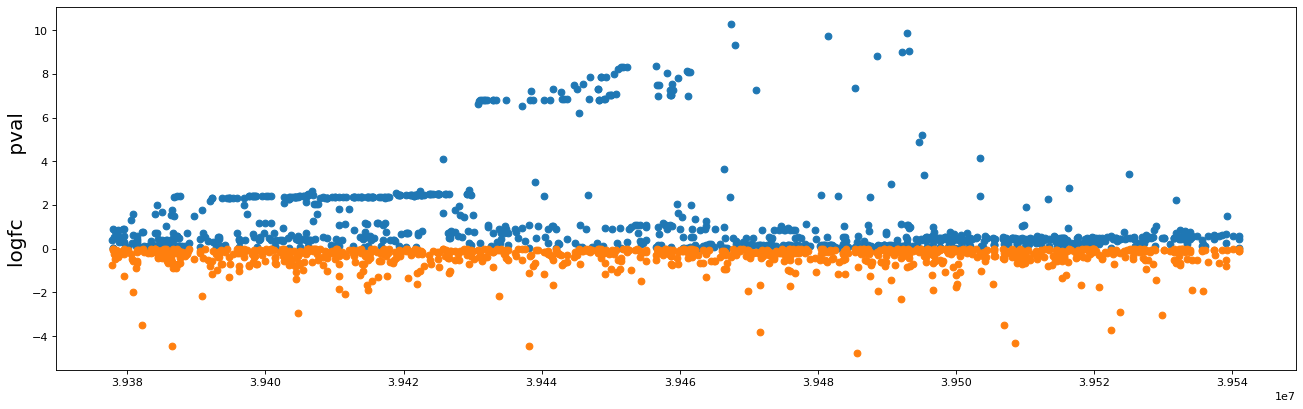

rsid chromo pos ref alt neg_log_pvalue abs_logfc jsd
rs115939603 chr3 39485731 A G 0.289374984939203 0.47917116 0.0549908213244523


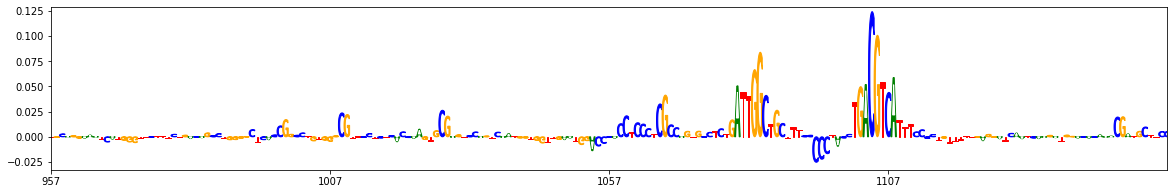

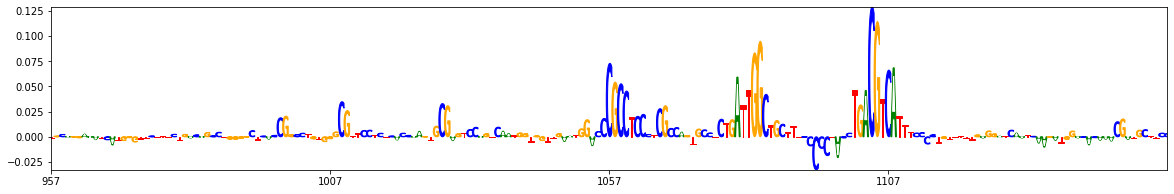

rsid chromo pos ref alt neg_log_pvalue abs_logfc jsd
rs142003765 chr3 39438120 A G 1.09231997575758 0.44633552 0.0912855700672385


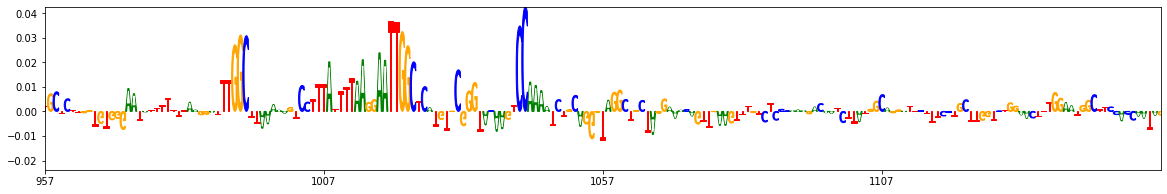

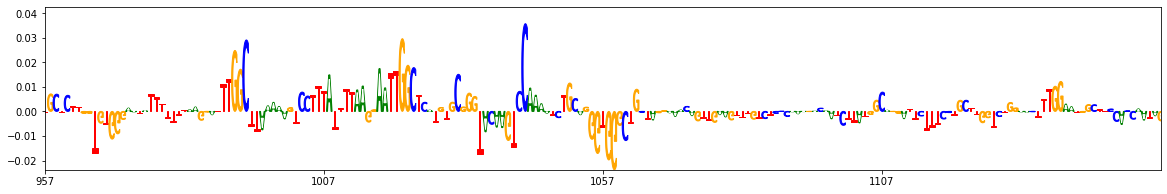

rsid chromo pos ref alt neg_log_pvalue abs_logfc jsd
rs512857 chr3 39508618 C T 0.470056598341331 0.43140897 0.0616020616076949


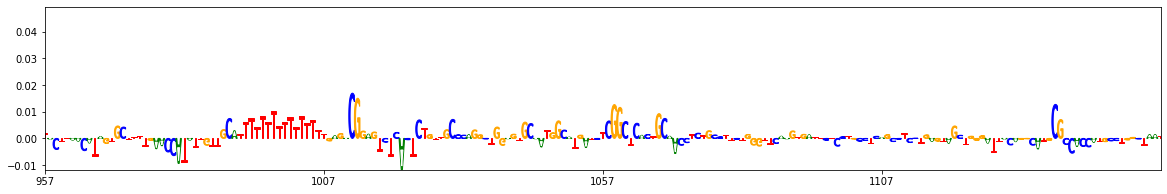

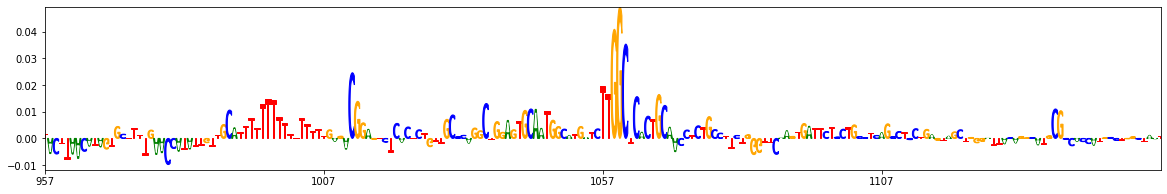

rsid chromo pos ref alt neg_log_pvalue abs_logfc jsd
rs625898 chr3 39471624 T A 0.147825095579697 0.3826758 0.0486400941583284


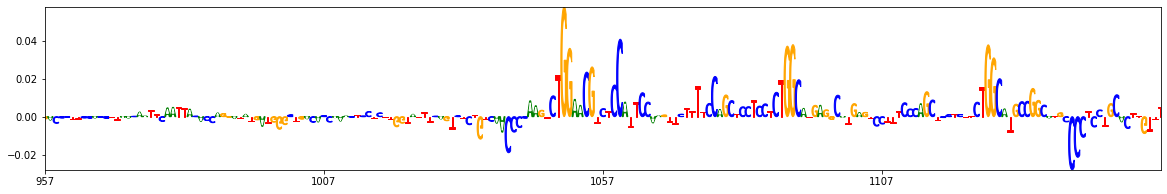

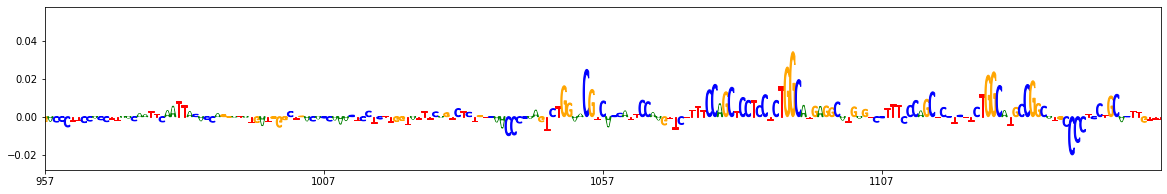

rsid chromo pos ref alt neg_log_pvalue abs_logfc jsd
rs1707969 chr3 39506998 T G 0.488919154460882 0.35014322 0.0468679313495716


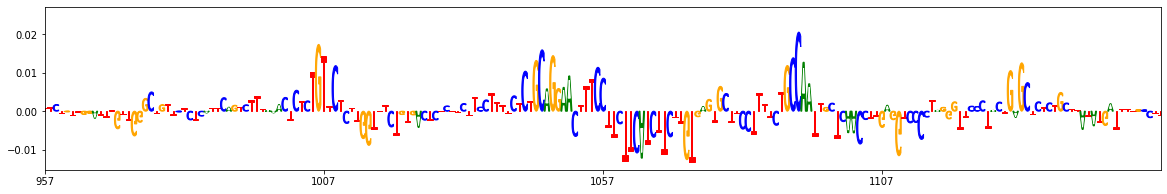

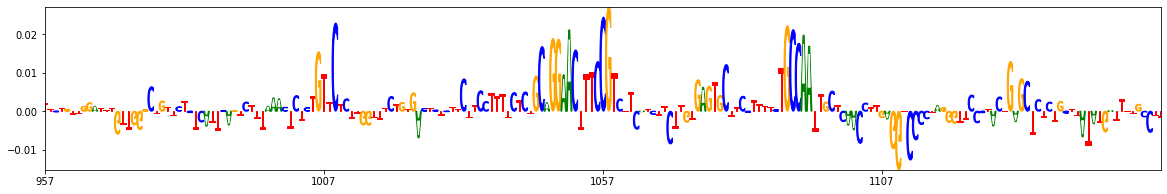

2
chr5 151002776 151068538


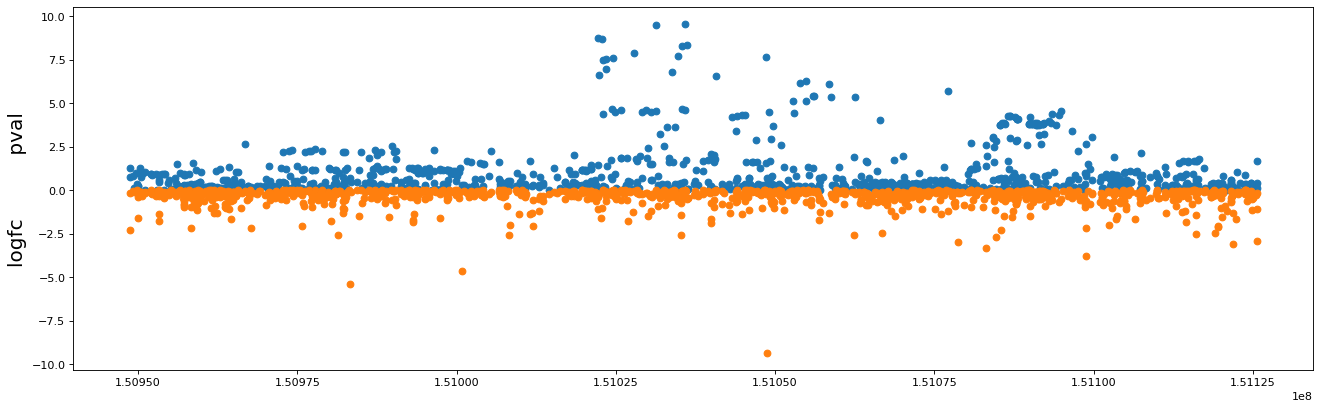

rsid chromo pos ref alt neg_log_pvalue abs_logfc jsd
rs75136045 chr5 151048744 C T 0.671620396561262 0.9390889 0.2215876451220801


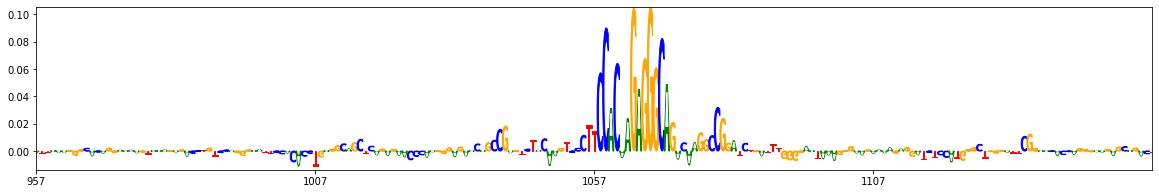

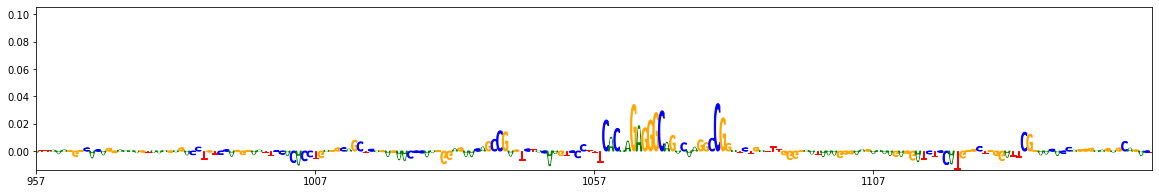

rsid chromo pos ref alt neg_log_pvalue abs_logfc jsd
rs17111703 chr5 151062420 A G 1.88773023158273 0.26046893 0.0354684307382305


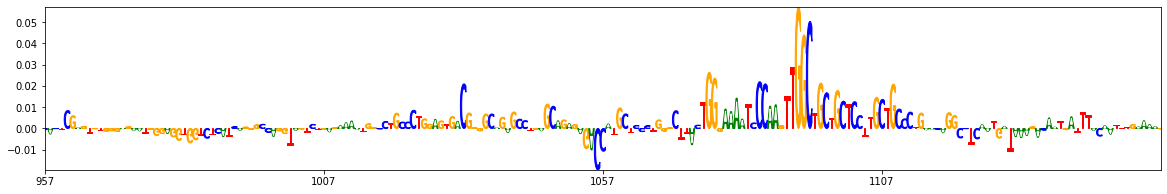

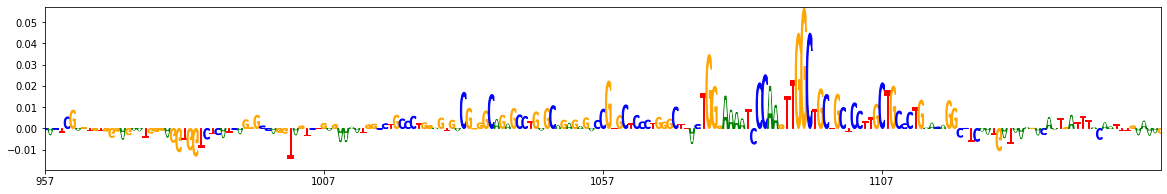

rsid chromo pos ref alt neg_log_pvalue abs_logfc jsd
rs2233304 chr5 151035148 C A 0.0192696234640547 0.25575098 0.0434862076401942


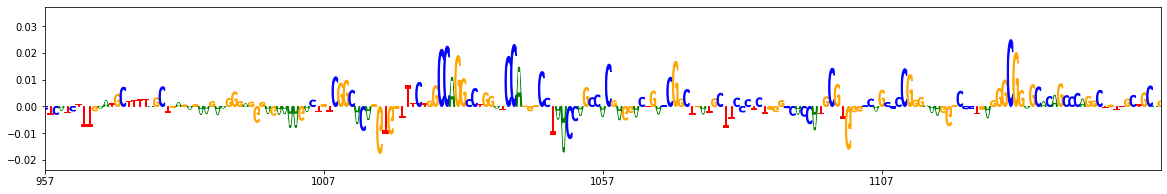

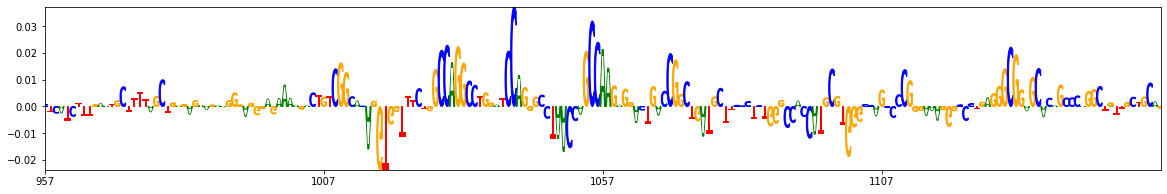

rsid chromo pos ref alt neg_log_pvalue abs_logfc jsd
rs6869405 chr5 151008174 C A 0.219970872662662 0.25571534 0.0373663568551928


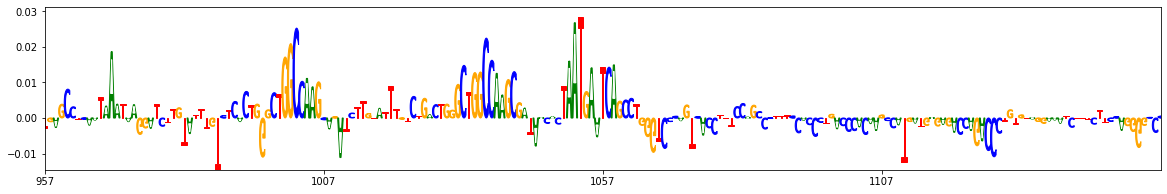

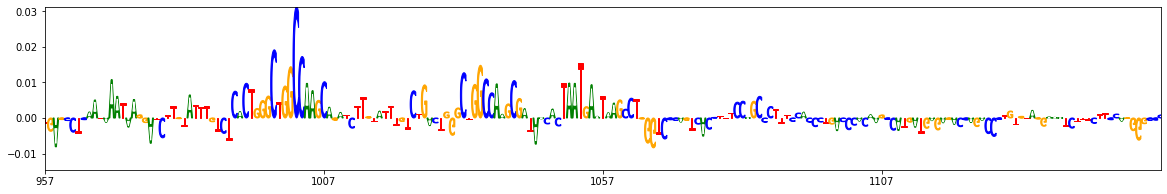

rsid chromo pos ref alt neg_log_pvalue abs_logfc jsd
rs1559126 chr5 151066843 C G 0.380072289708532 0.2453929 0.0271345463211685


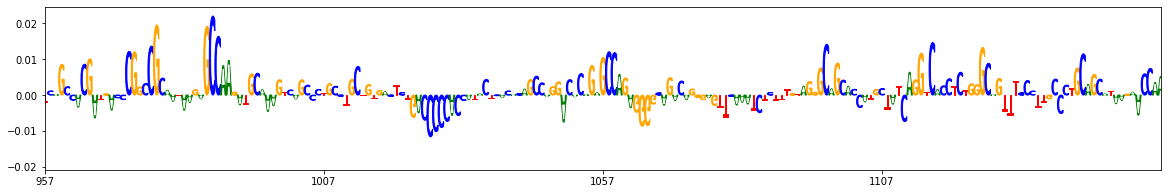

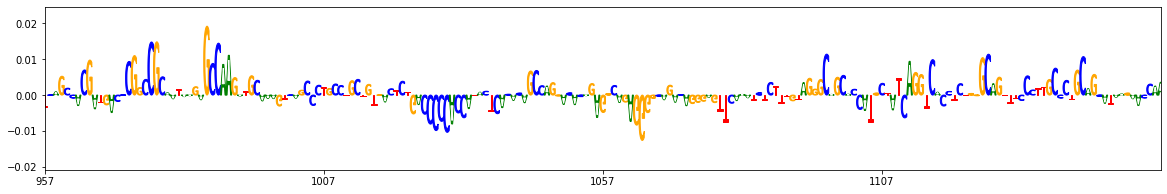

3
chr5 172900766 172948635


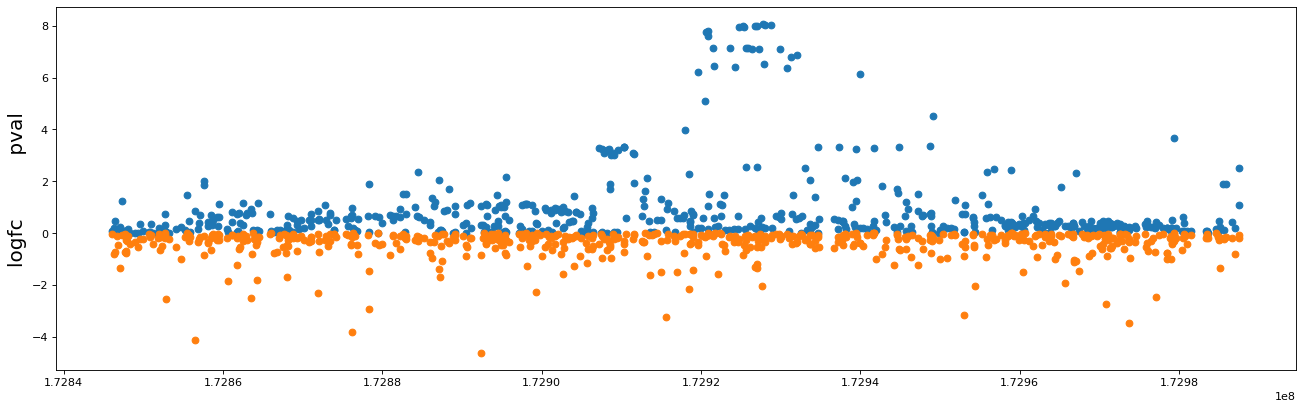

rsid chromo pos ref alt neg_log_pvalue abs_logfc jsd
rs145748219 chr5 172915596 C T 0.111146833017064 0.324769 0.0409547063879864


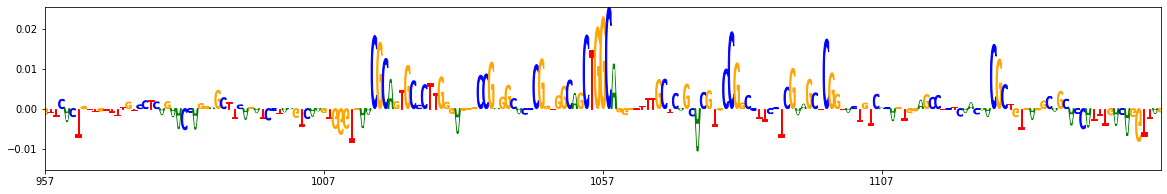

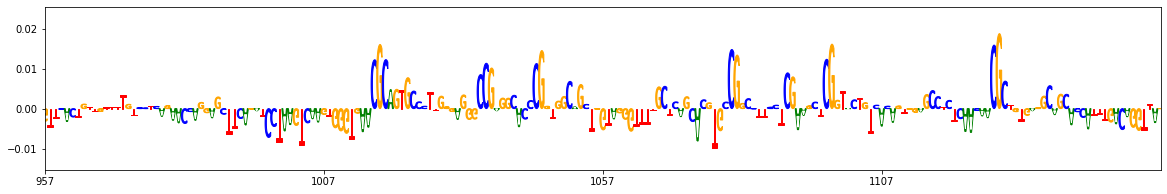

rsid chromo pos ref alt neg_log_pvalue abs_logfc jsd
rs481221 chr5 172918532 A G 2.28776964543909 0.2169298 0.0332113091115546


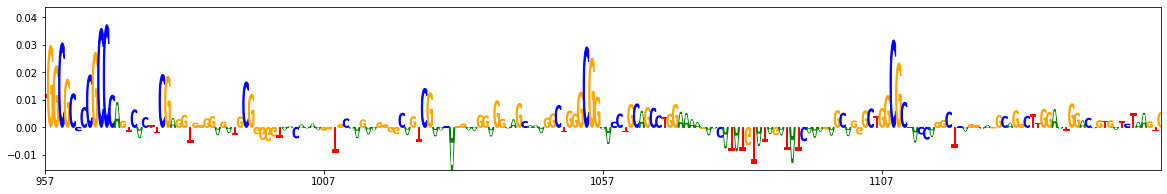

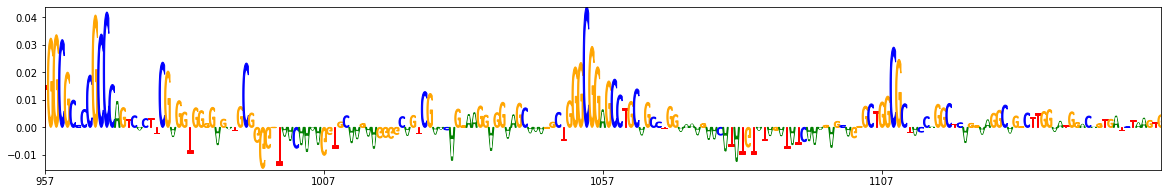

rsid chromo pos ref alt neg_log_pvalue abs_logfc jsd
rs142705813 chr5 172927648 C T 0.221270076003888 0.203772 0.0338504224473439


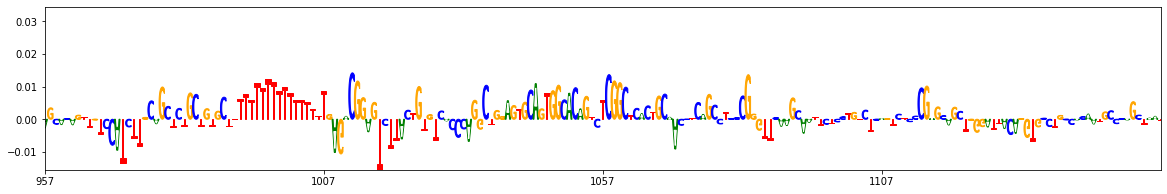

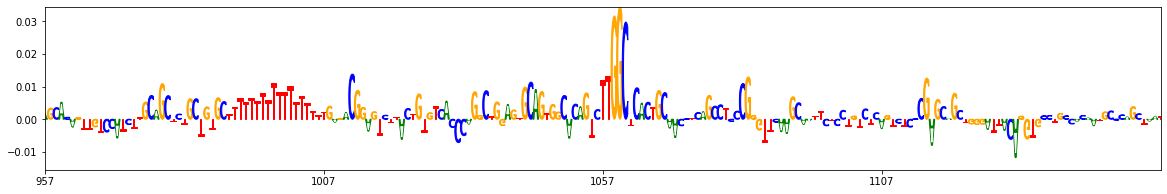

rsid chromo pos ref alt neg_log_pvalue abs_logfc jsd
rs76404116 chr5 172913556 G A 0.0259490972071227 0.16128166 0.0288191913250674


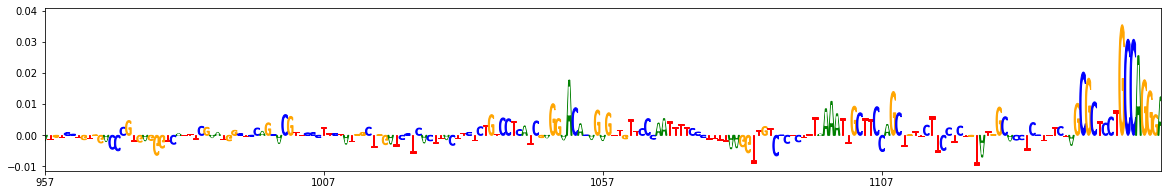

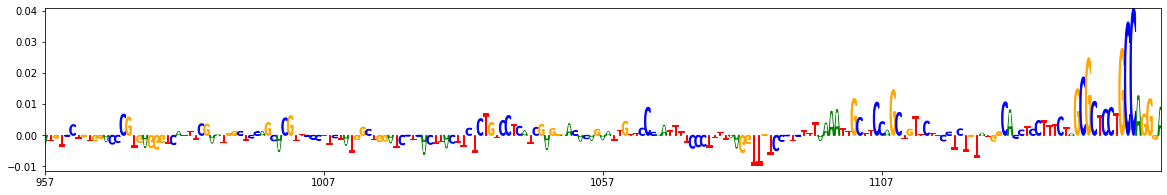

rsid chromo pos ref alt neg_log_pvalue abs_logfc jsd
rs116813526 chr5 172922138 C T 0.277778359338125 0.15714712 0.024811927656763


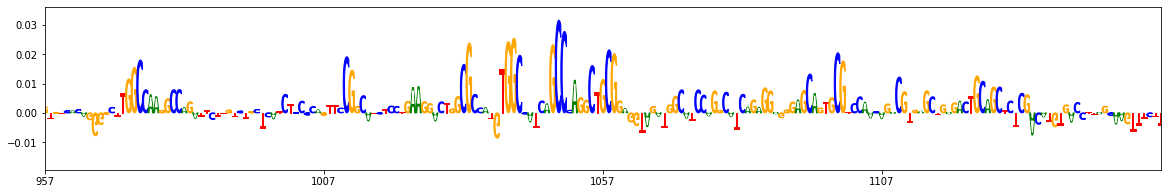

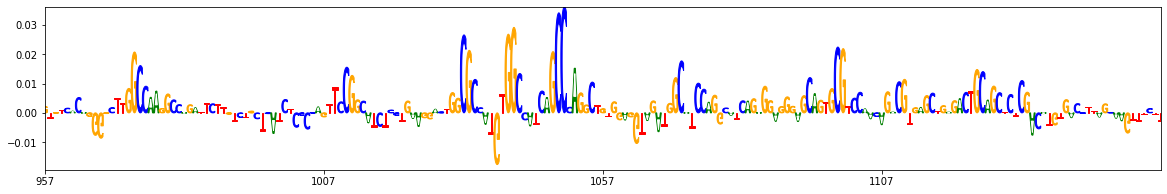

4
chr6 31618847 31658087


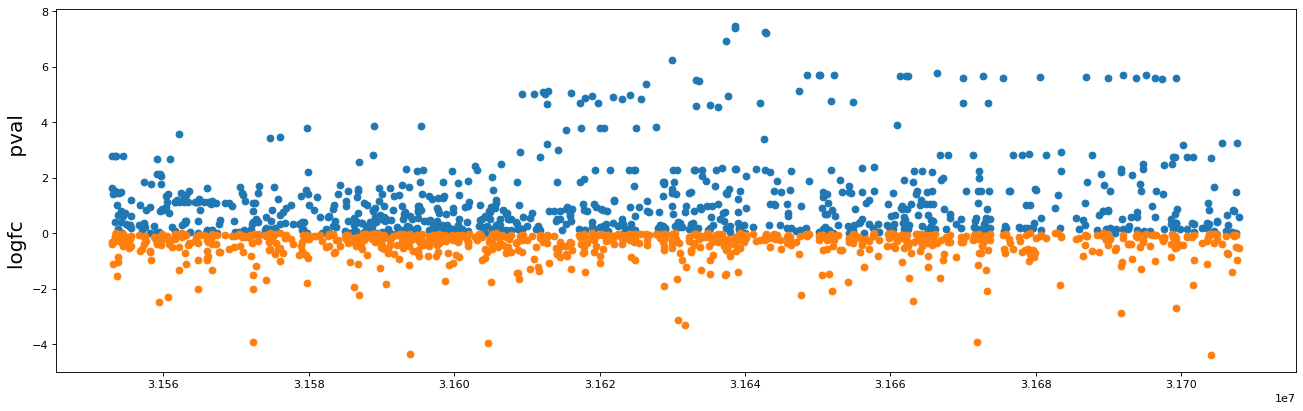

rsid chromo pos ref alt neg_log_pvalue abs_logfc jsd
rs78503551 chr6 31631779 A C 0.768275616671484 0.330302 0.0634829517963594


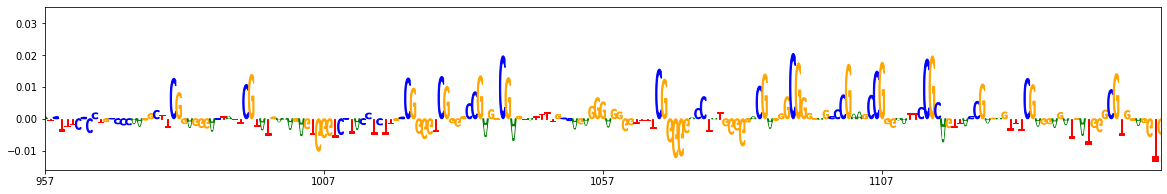

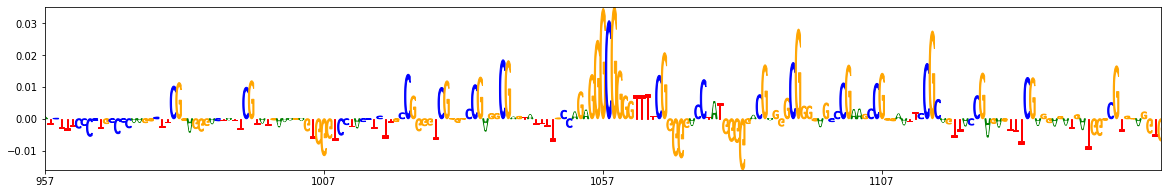

rsid chromo pos ref alt neg_log_pvalue abs_logfc jsd
rs11538262 chr6 31630746 C T 0.388382889445664 0.314102 0.0406349459953311


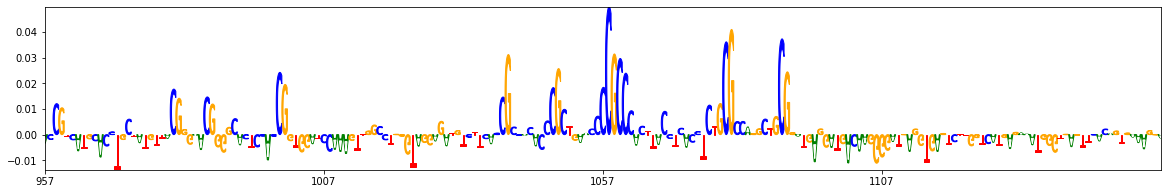

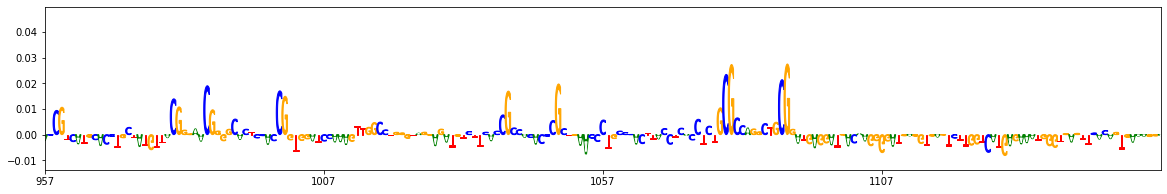

rsid chromo pos ref alt neg_log_pvalue abs_logfc jsd
rs10484558 chr6 31647737 T C 0.996108833763089 0.2229741 0.0366533455291515


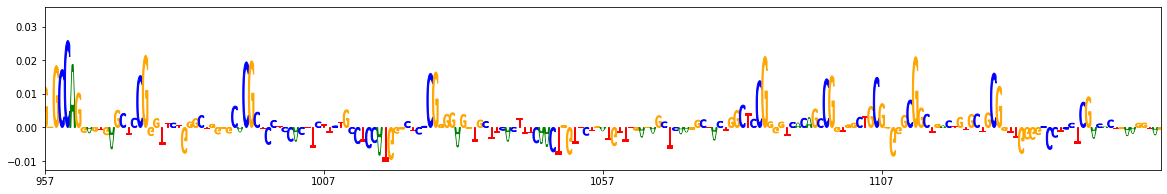

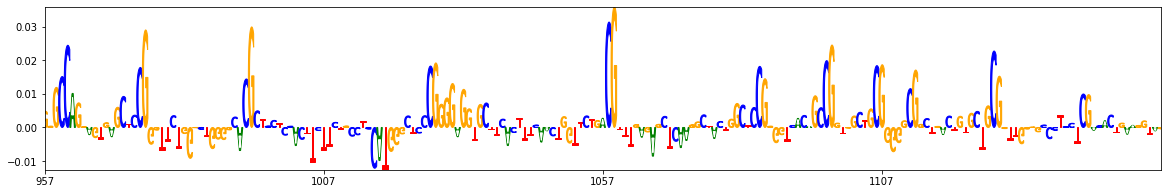

rsid chromo pos ref alt neg_log_pvalue abs_logfc jsd
rs534169983 chr6 31651993 G T 0.850472986245652 0.20705912 0.0445339724896401


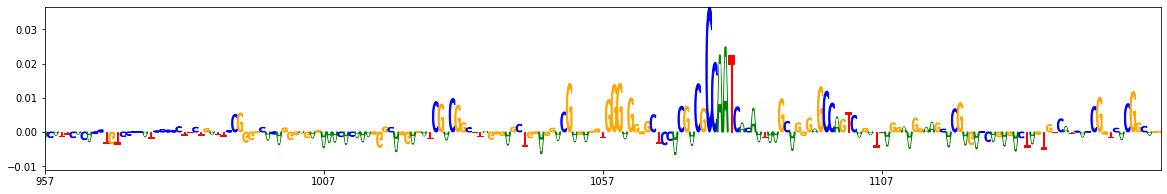

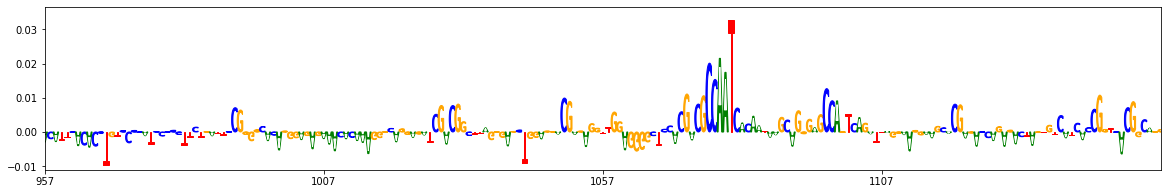

rsid chromo pos ref alt neg_log_pvalue abs_logfc jsd
rs148613310 chr6 31628796 A G 0.147337055655431 0.19103858 0.0197176030085363


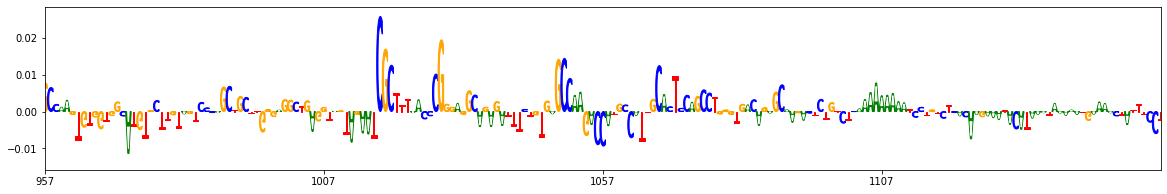

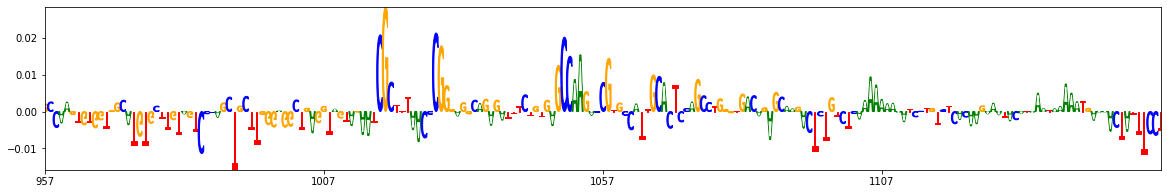

5
chr6 32684770 32734335


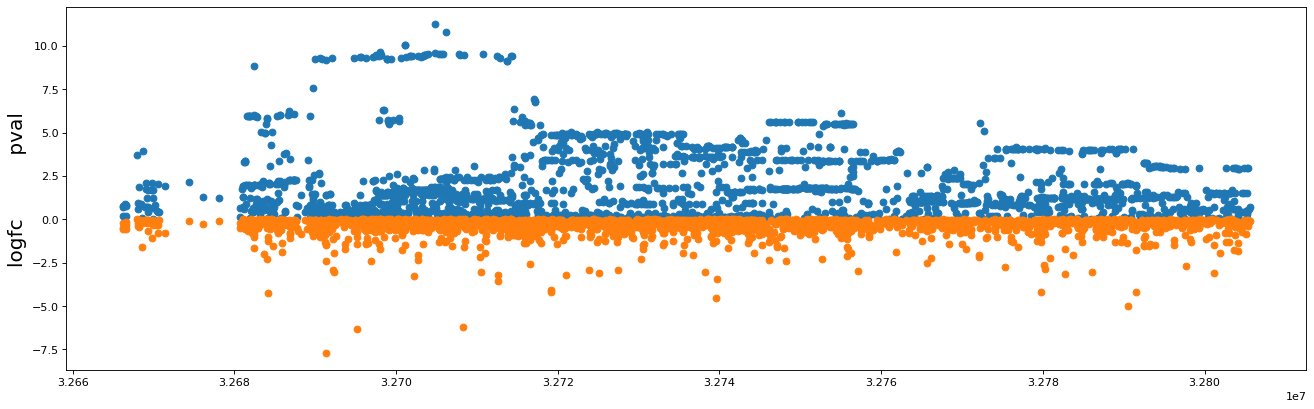

rsid chromo pos ref alt neg_log_pvalue abs_logfc jsd
rs5002702 chr6 32691381 G A 0.137451230475207 0.77306294 0.1113929935997575


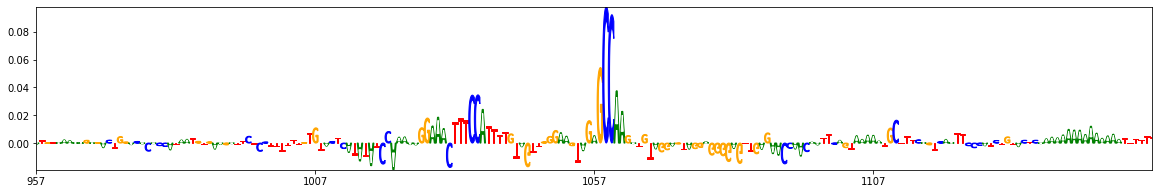

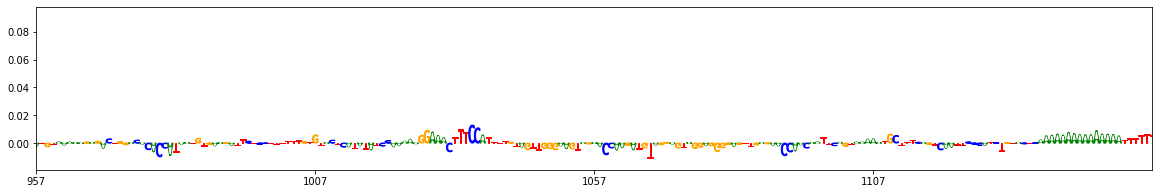

rsid chromo pos ref alt neg_log_pvalue abs_logfc jsd
rs2856670 chr6 32695127 G C 0.186953034839892 0.63405347 0.1054706926520127


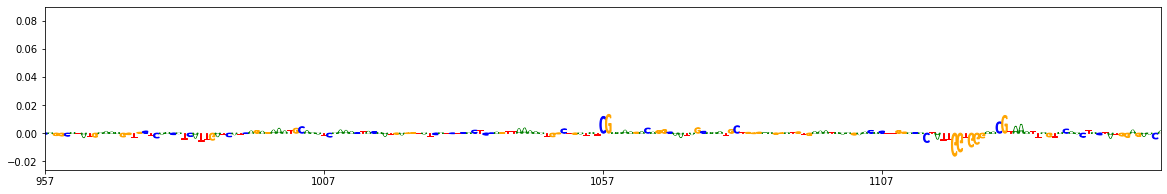

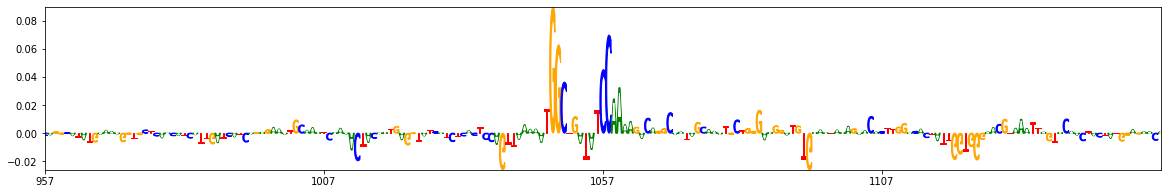

rsid chromo pos ref alt neg_log_pvalue abs_logfc jsd
rs28371289 chr6 32708298 A G 0.413525221428603 0.62235475 0.063142104434084


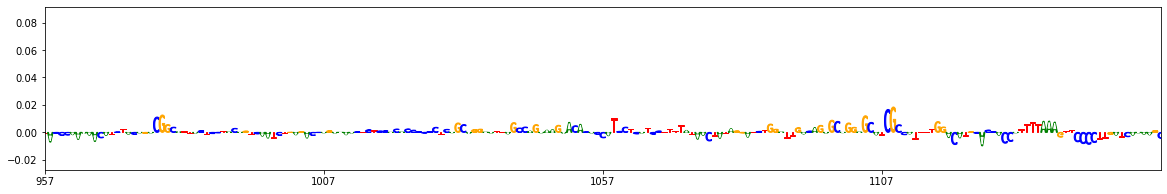

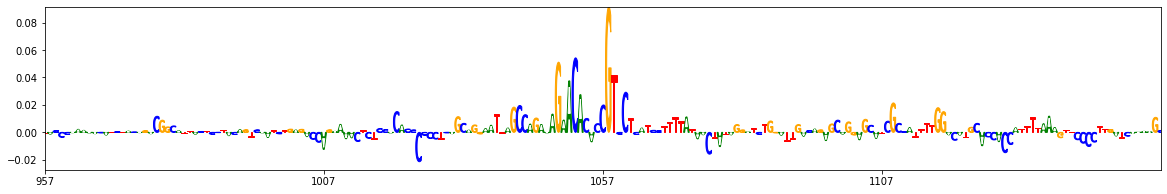

rsid chromo pos ref alt neg_log_pvalue abs_logfc jsd
rs149332897 chr6 32719145 C T 0.912218582190458 0.41742146 0.0529638766794028


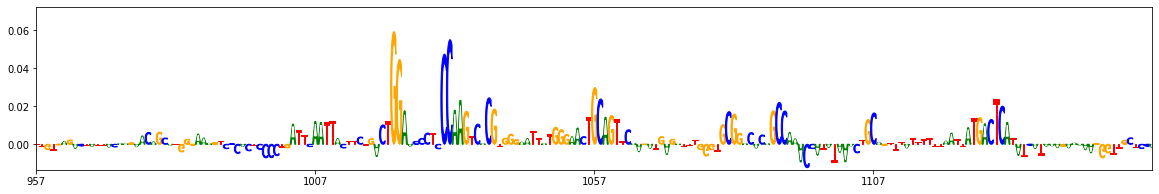

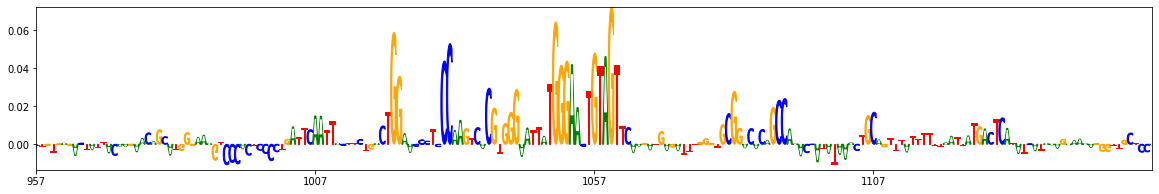

rsid chromo pos ref alt neg_log_pvalue abs_logfc jsd
rs3129740 chr6 32719144 G A 4.88639084892697 0.40811738 0.0381134282445814


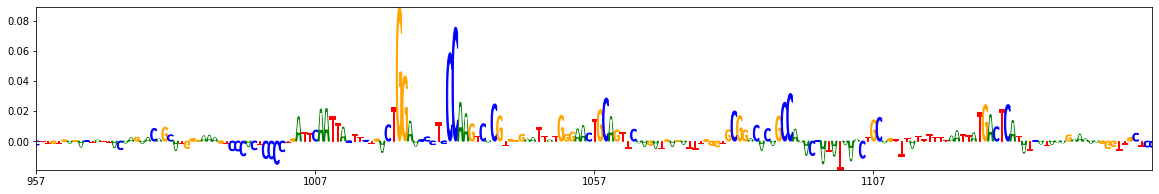

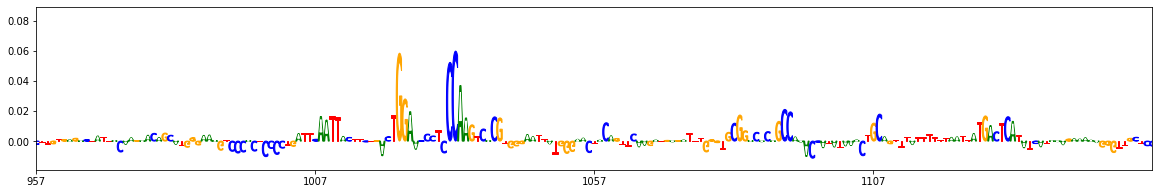

6
chr9 27249126 28551708


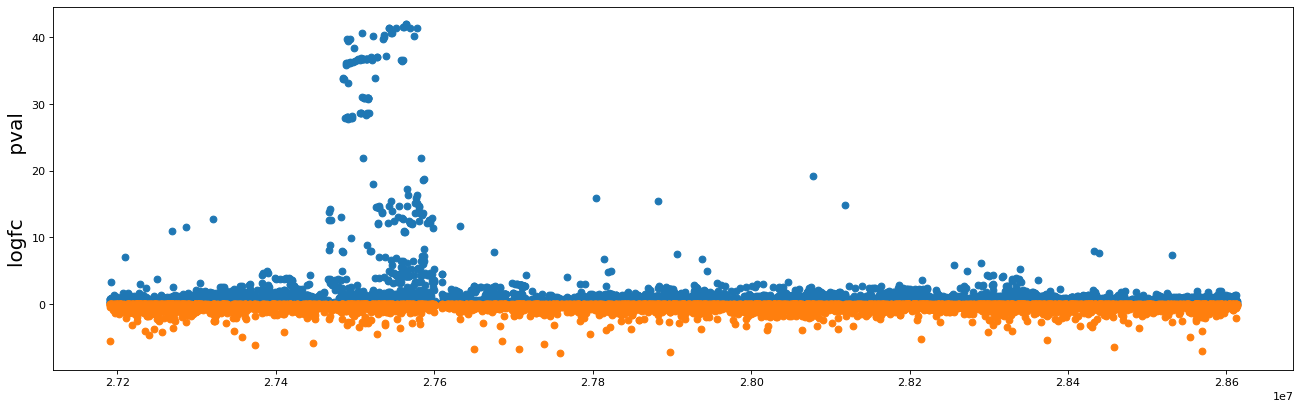

rsid chromo pos ref alt neg_log_pvalue abs_logfc jsd
rs1539272 chr9 27758253 G C 0.172179217916729 0.7398257 0.1640461959003664


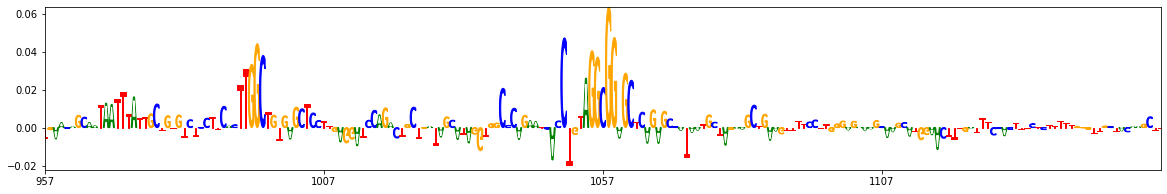

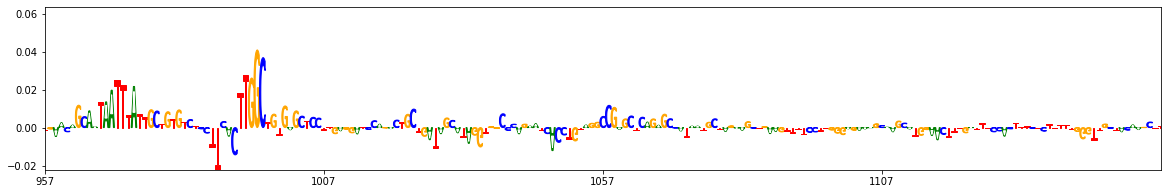

rsid chromo pos ref alt neg_log_pvalue abs_logfc jsd
rs10812683 chr9 27898047 C A 2.29021970367798 0.7129396 0.1193525703876036


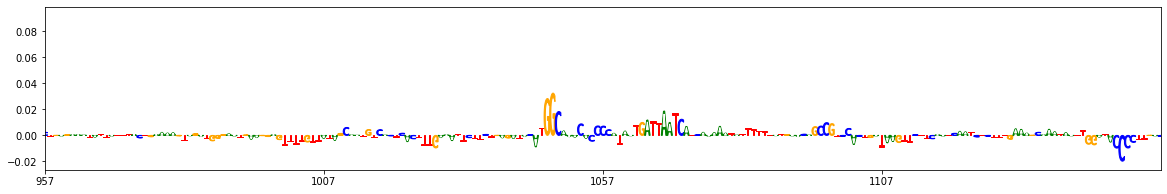

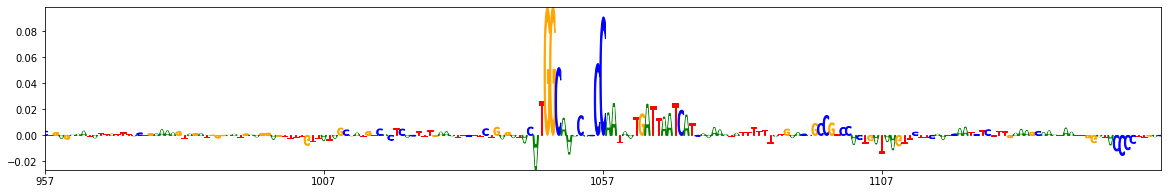

rsid chromo pos ref alt neg_log_pvalue abs_logfc jsd
rs113781789 chr9 27707116 C T 0.219898808532088 0.6775756 0.0780720262935824


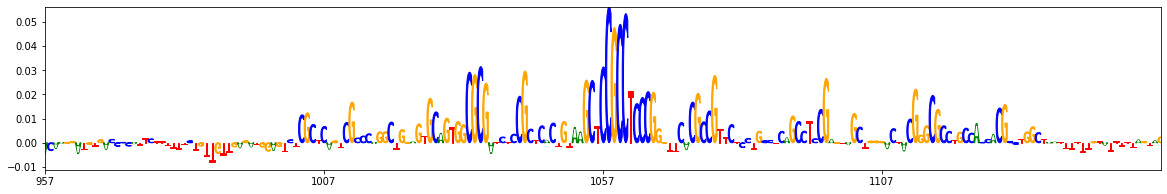

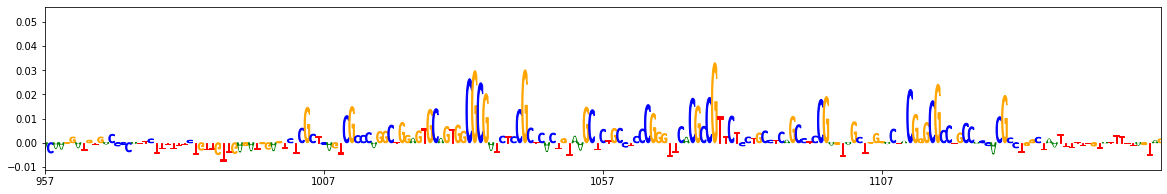

rsid chromo pos ref alt neg_log_pvalue abs_logfc jsd
rs7851612 chr9 27650710 G C 2.66595057214379 0.6743673 0.1017529874525332


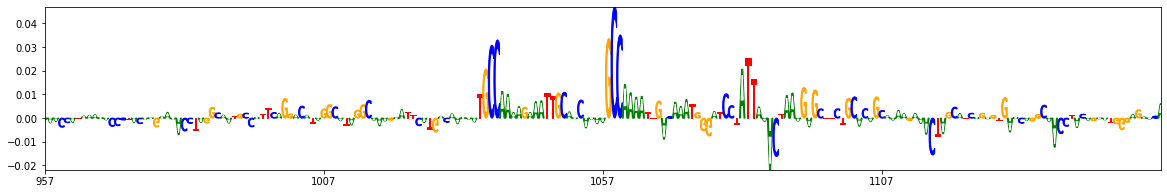

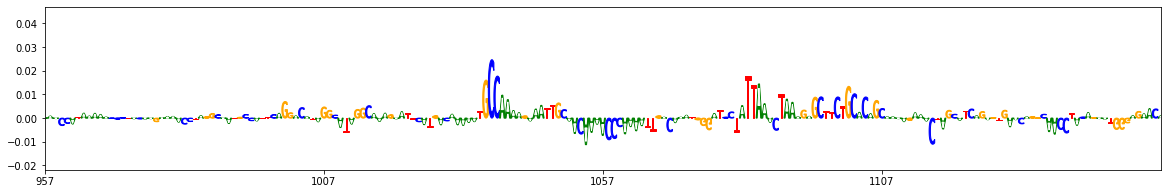

rsid chromo pos ref alt neg_log_pvalue abs_logfc jsd
rs75281408 chr9 28458578 T G 0.189430799021567 0.63971496 0.1162607823391115


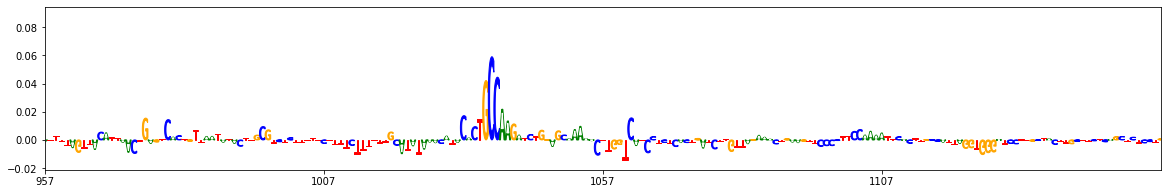

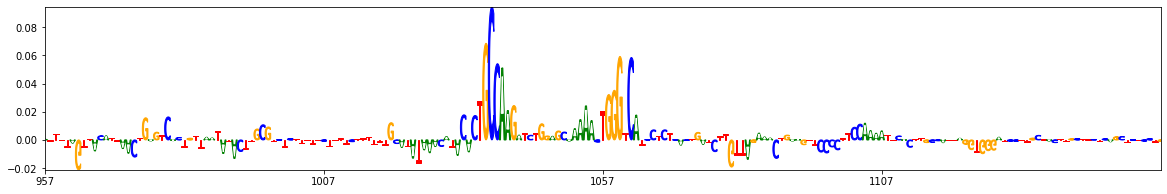

7
chr12 57562074 58282157


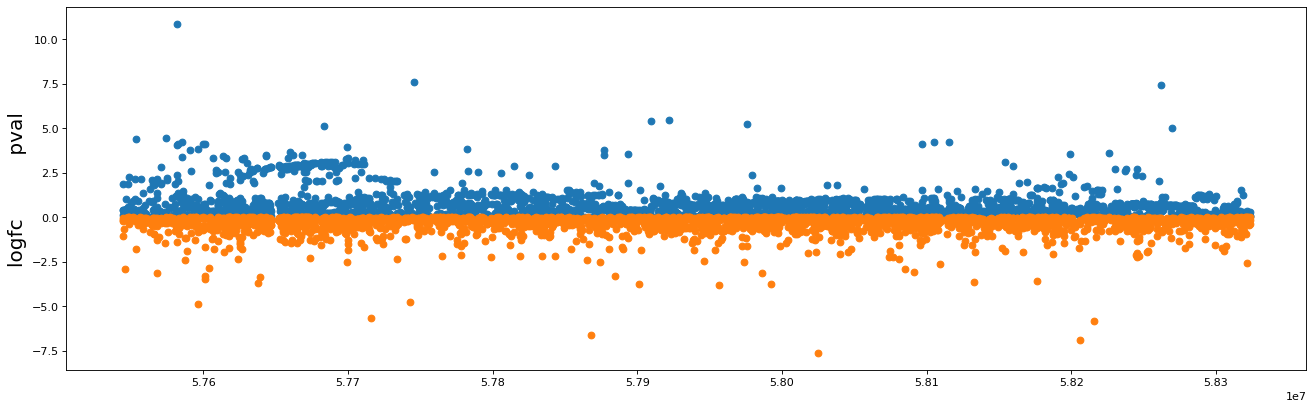

rsid chromo pos ref alt neg_log_pvalue abs_logfc jsd
rs1605335 chr12 58024755 C T 1.01314007261395 0.76580006 0.1232312879261566


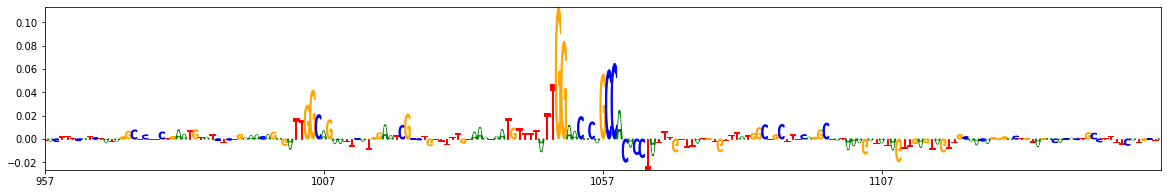

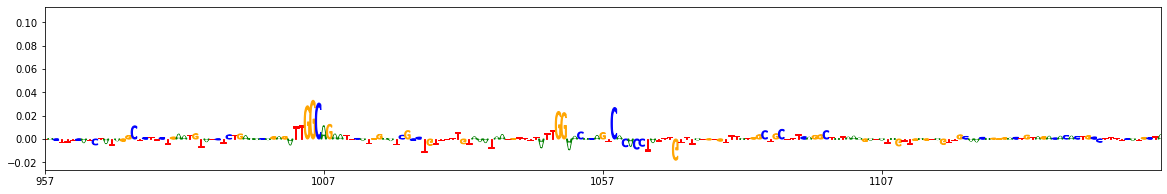

rsid chromo pos ref alt neg_log_pvalue abs_logfc jsd
rs186149480 chr12 58206328 G A 0.0507075985879743 0.6896137 0.1366505725352049


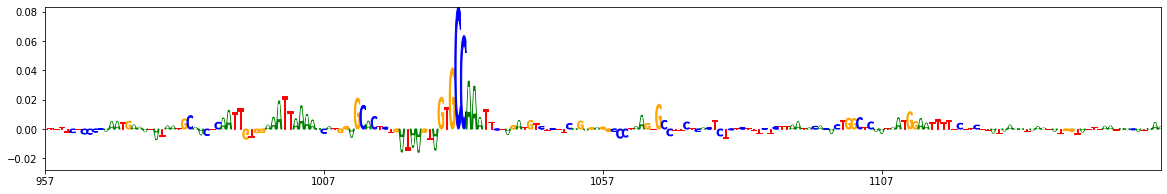

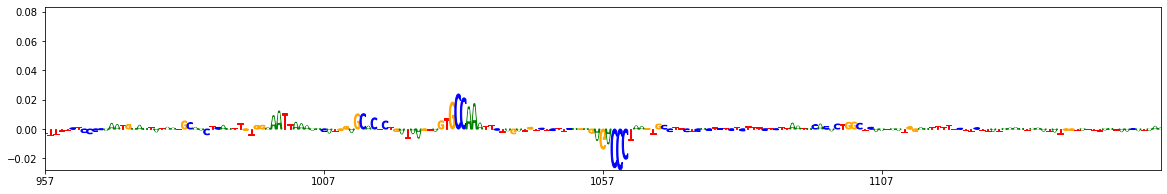

rsid chromo pos ref alt neg_log_pvalue abs_logfc jsd
rs5017863 chr12 57867878 C T 0.455064234118497 0.66371 0.0762313311178897


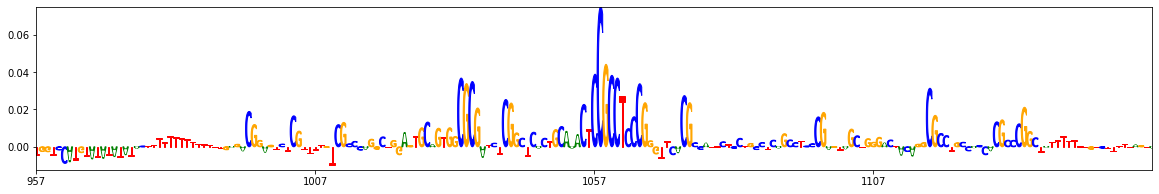

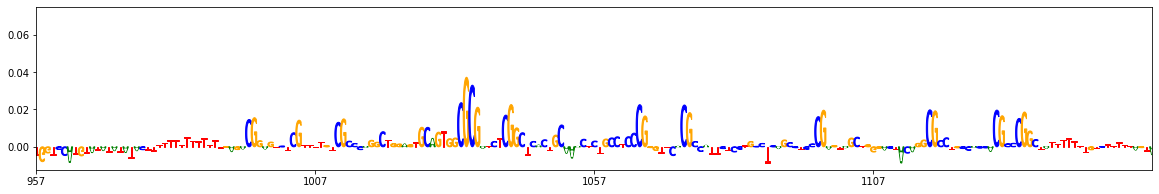

rsid chromo pos ref alt neg_log_pvalue abs_logfc jsd
rs61938467 chr12 58215983 T A 0.73471037413917 0.58382744 0.101427515816874


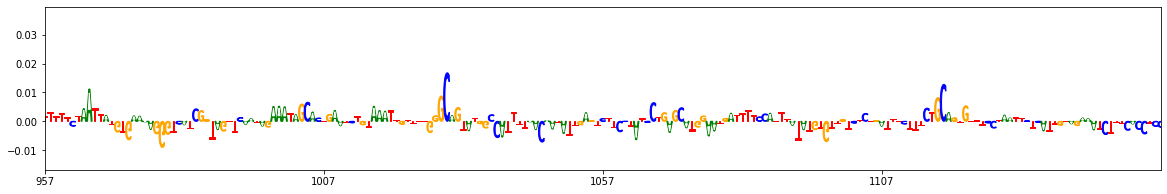

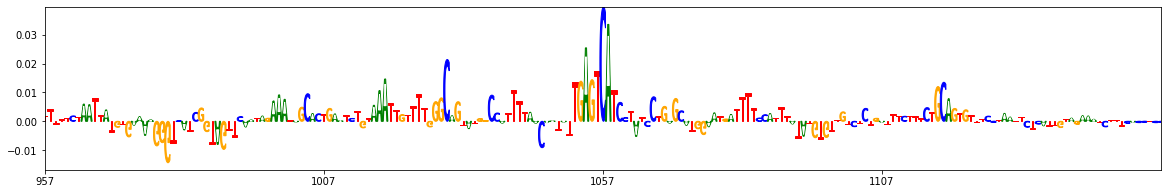

rsid chromo pos ref alt neg_log_pvalue abs_logfc jsd
rs76103081 chr12 57716020 G T 0.264002115908206 0.5684733 0.090550493574535


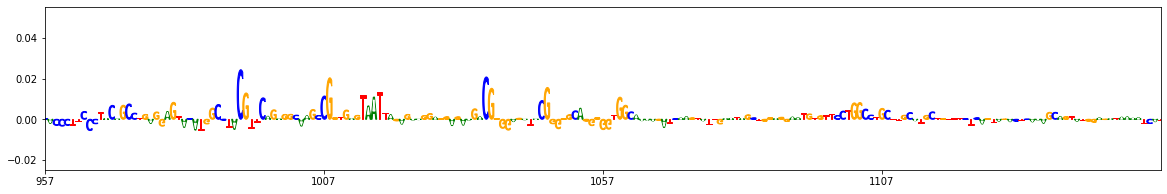

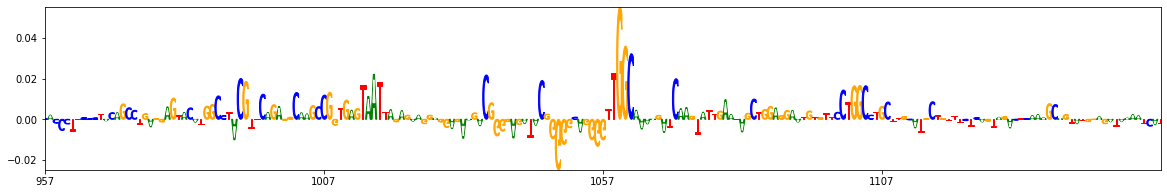

8
chr12 64335541 64523972


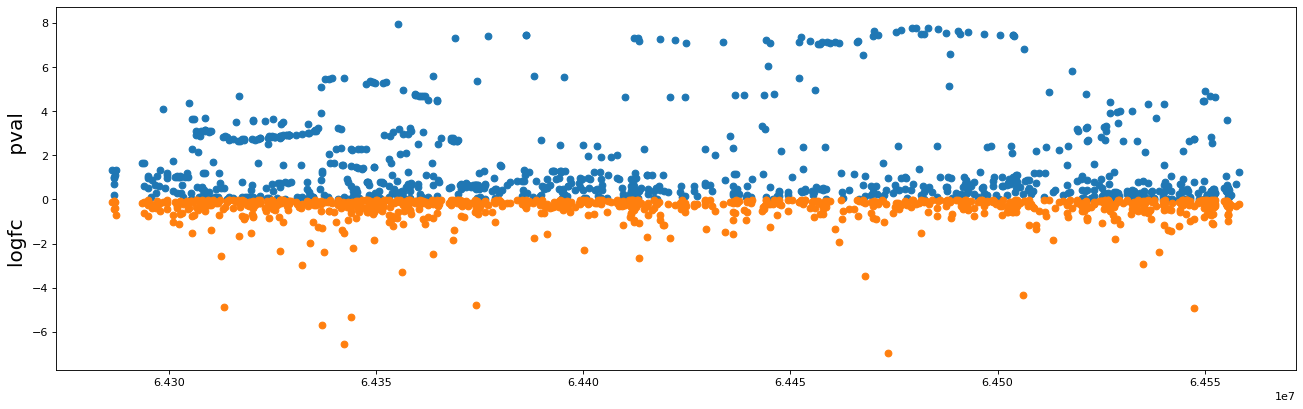

rsid chromo pos ref alt neg_log_pvalue abs_logfc jsd
rs10878175 chr12 64473558 C G 0.978810700930062 0.6970849 0.1028847317539413


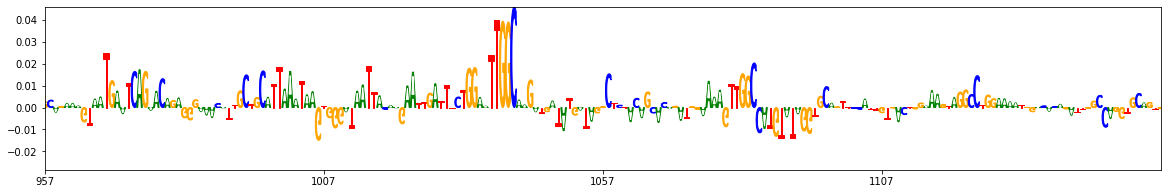

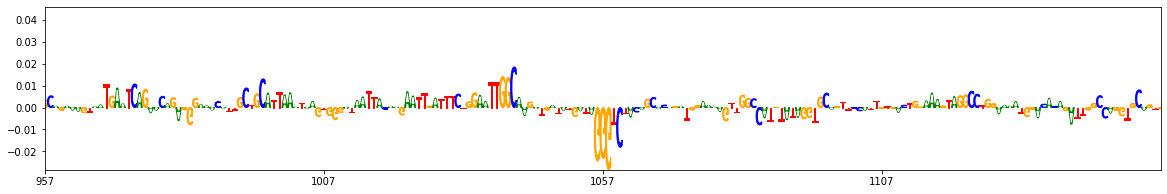

rsid chromo pos ref alt neg_log_pvalue abs_logfc jsd
rs61931512 chr12 64342193 G A 5.48837996810873 0.6554102 0.0857692311983523


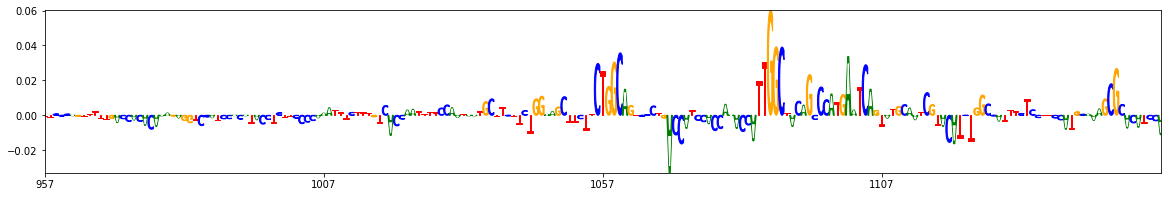

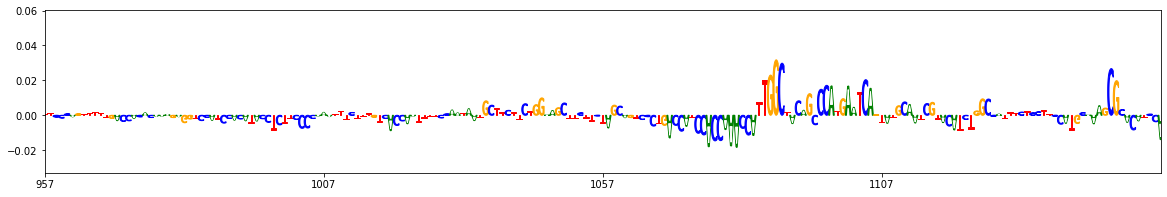

rsid chromo pos ref alt neg_log_pvalue abs_logfc jsd
rs6581545 chr12 64336793 G T 1.30998033253503 0.5677283 0.0743679316652071


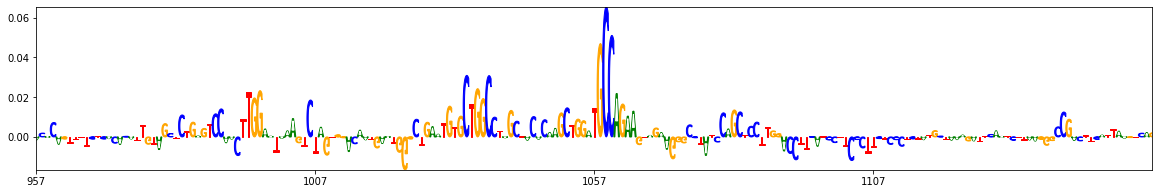

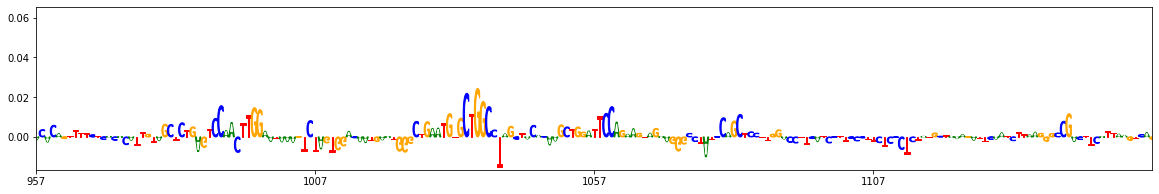

rsid chromo pos ref alt neg_log_pvalue abs_logfc jsd
rs117292206 chr12 64343922 G A 1.49729982468944 0.5334331 0.0852057339443555


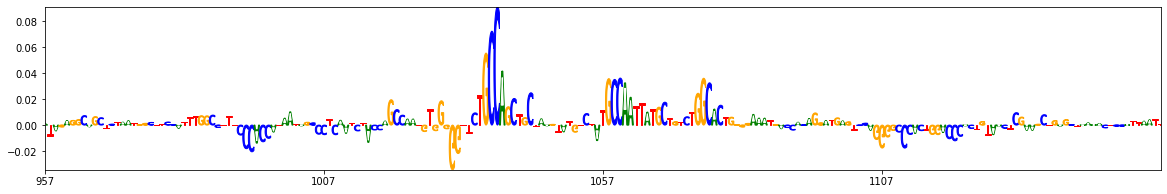

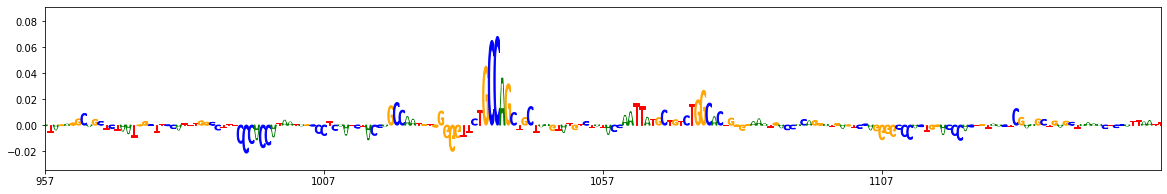

rsid chromo pos ref alt neg_log_pvalue abs_logfc jsd
rs74493096 chr12 64374027 G T 0.676129393459491 0.4797682 0.0995220521497621


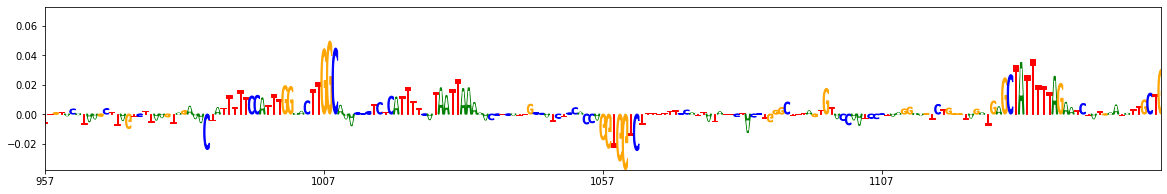

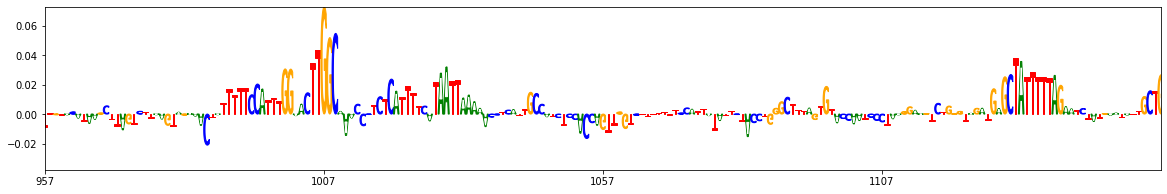

9
chr14 30511704 30749487


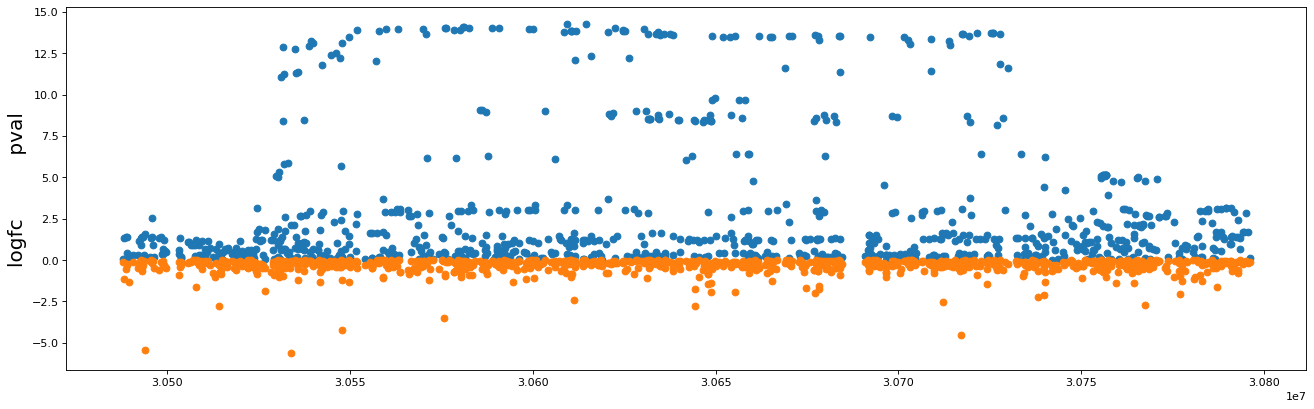

rsid chromo pos ref alt neg_log_pvalue abs_logfc jsd
rs74844603 chr14 30533908 T C 2.11283016340843 0.5636943 0.1015626375490871


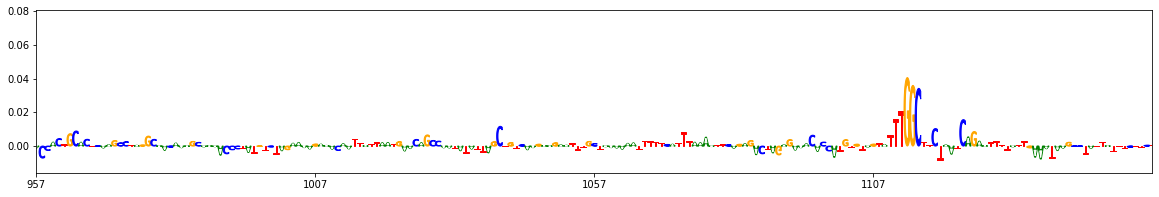

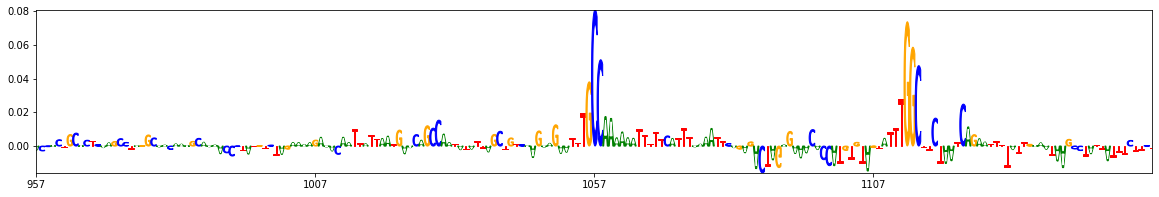

rsid chromo pos ref alt neg_log_pvalue abs_logfc jsd
rs150636198 chr14 30717103 A G 0.0242925364628199 0.44978583 0.0719916330317207


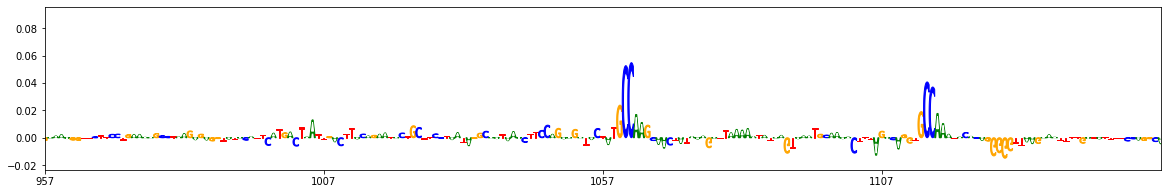

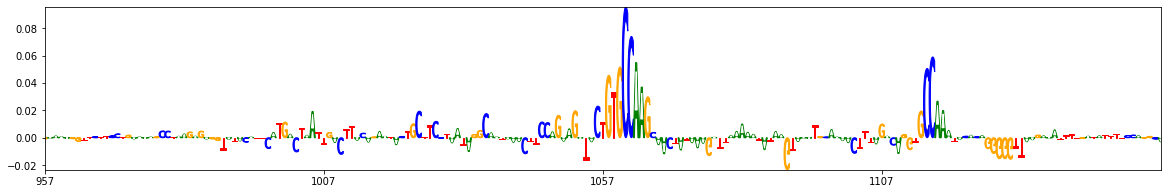

rsid chromo pos ref alt neg_log_pvalue abs_logfc jsd
rs229171 chr14 30547852 T C 13.1295001157115 0.4252059 0.0777703700282162


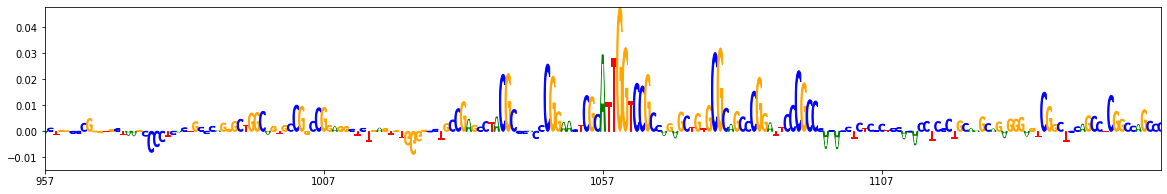

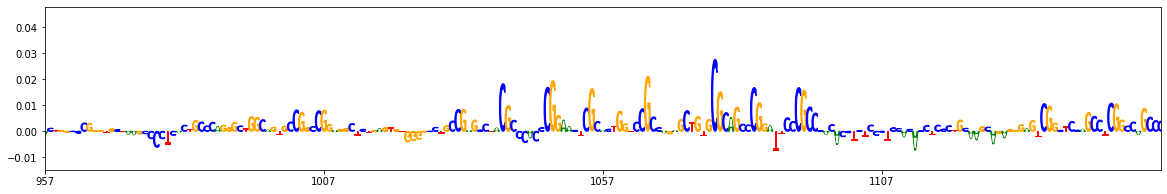

rsid chromo pos ref alt neg_log_pvalue abs_logfc jsd
rs229192 chr14 30575892 T C 0.497436330892637 0.35128635 0.0571747742431492


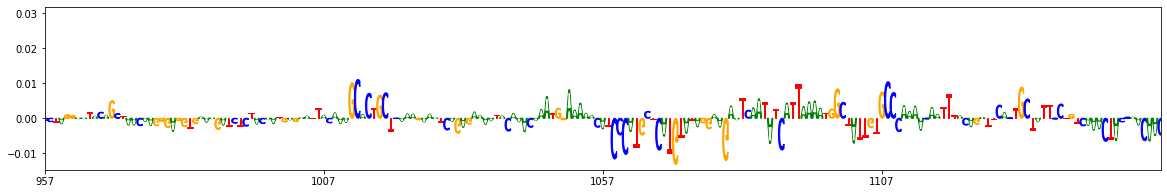

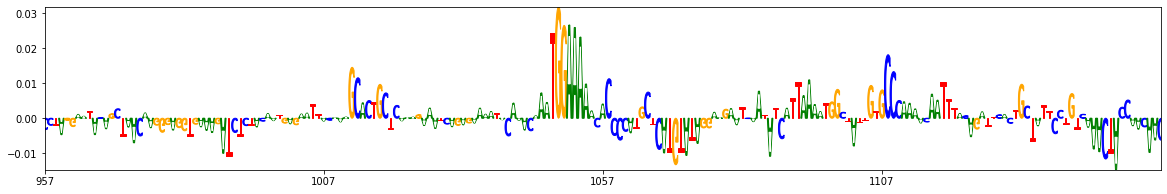

rsid chromo pos ref alt neg_log_pvalue abs_logfc jsd
rs117842165 chr14 30514411 A C 0.431915668684606 0.27979815 0.0331069907960996


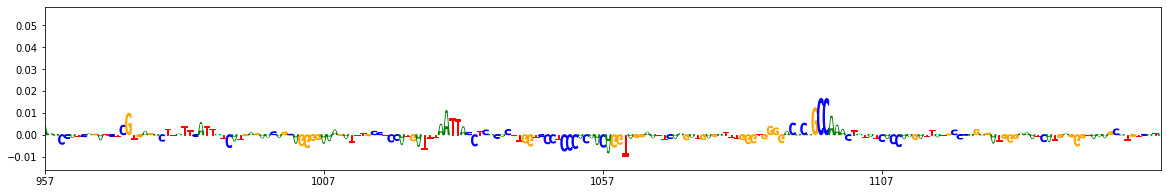

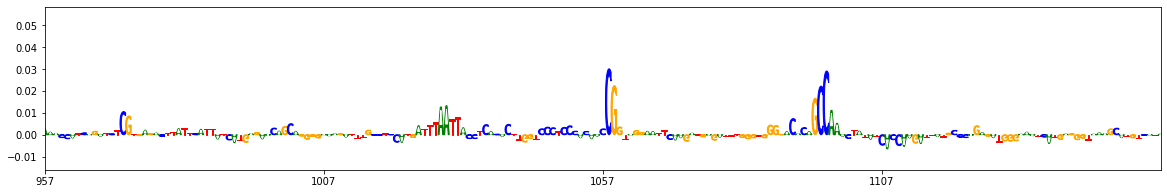

10
chr19 17611950 17663453


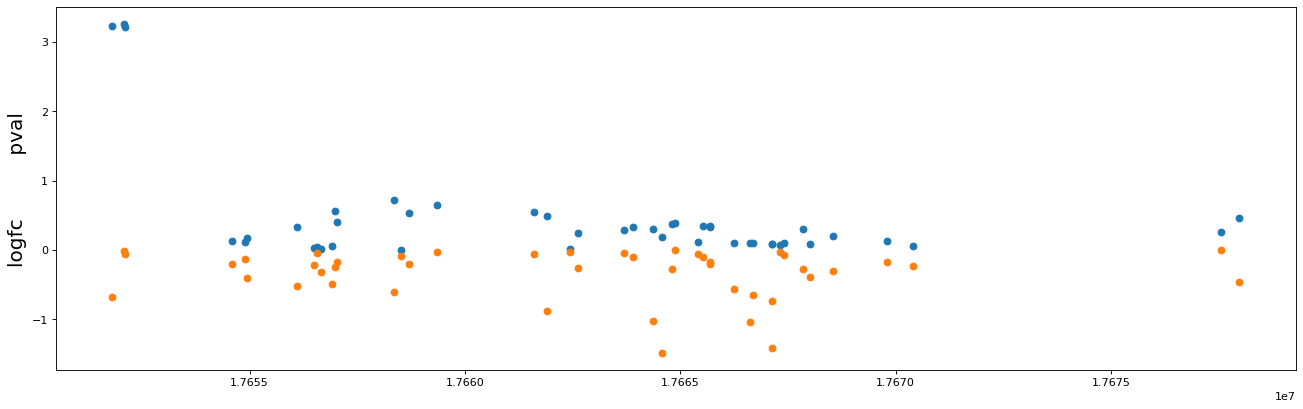

rsid chromo pos ref alt neg_log_pvalue abs_logfc jsd
rs4239633 chr19 17631660 C T 18.6475994243009 0.235838 0.0366881329134167


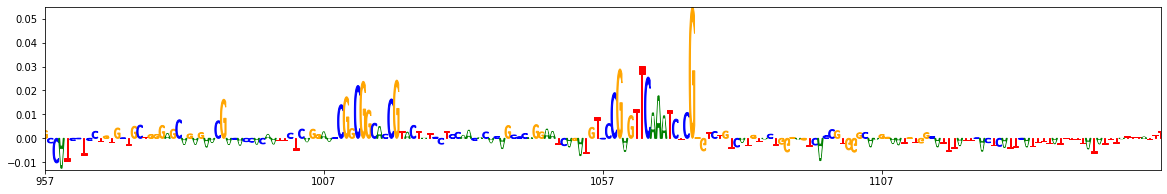

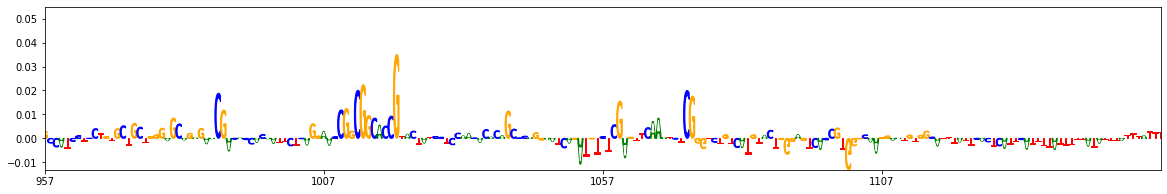

rsid chromo pos ref alt neg_log_pvalue abs_logfc jsd
rs11668114 chr19 17651527 C G 1.03650022428425 0.21717778 0.0395870307530864


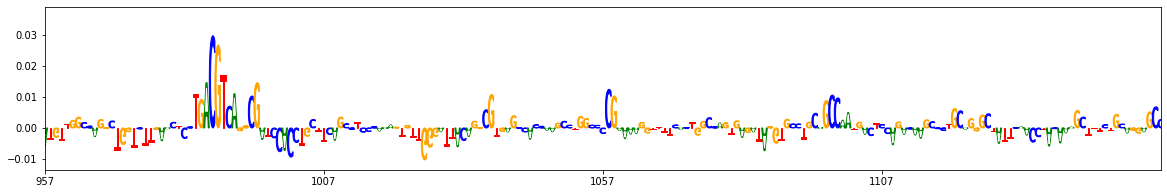

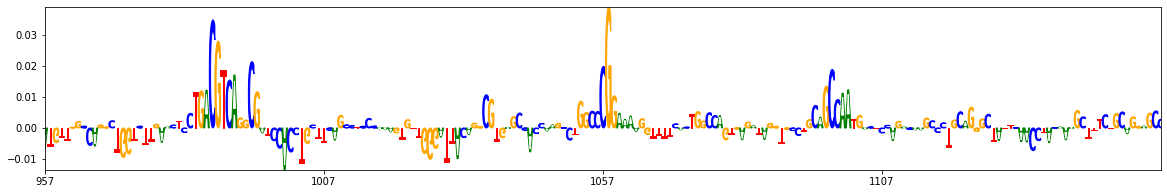

11
chr20 49798973 50025801


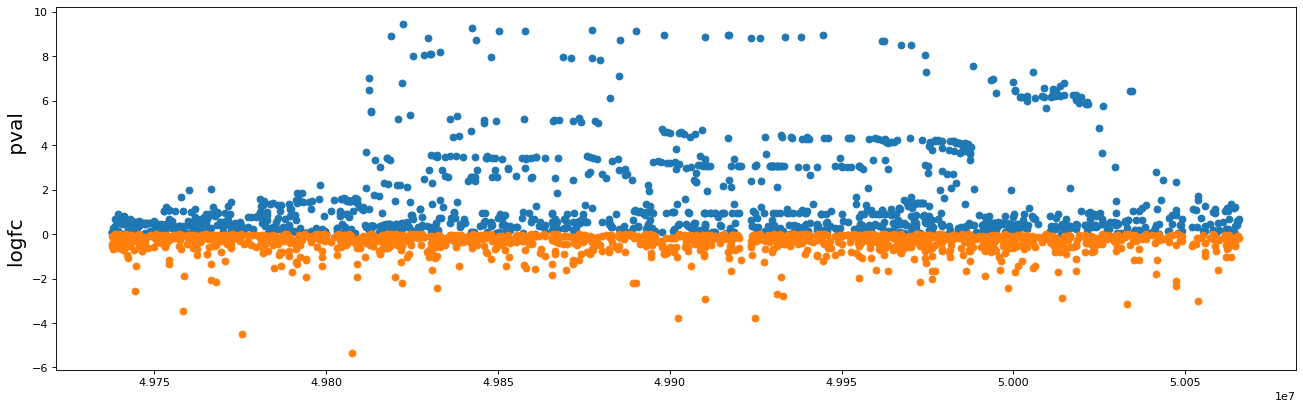

rsid chromo pos ref alt neg_log_pvalue abs_logfc jsd
rs592855 chr20 49807531 G A 0.0587868124146787 0.5367373 0.1302885873155368


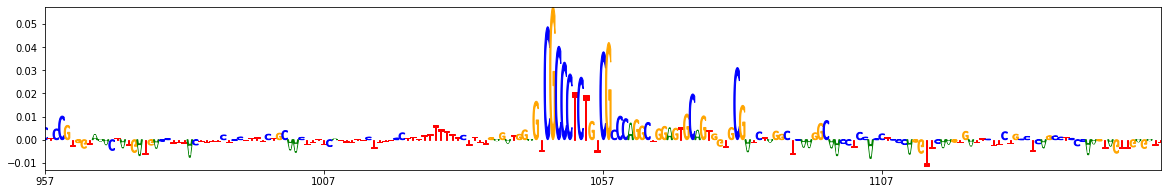

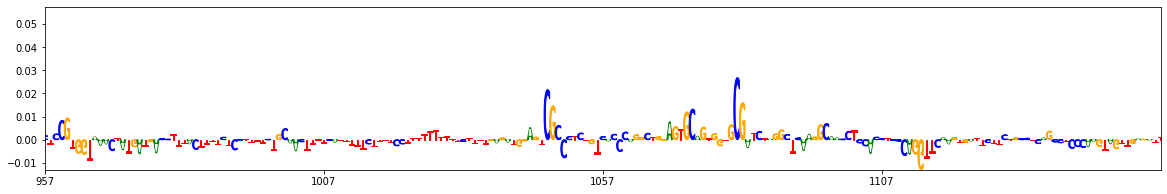

rsid chromo pos ref alt neg_log_pvalue abs_logfc jsd
rs74837988 chr20 49924656 G A 0.934420285271552 0.37891904 0.0767956465742212


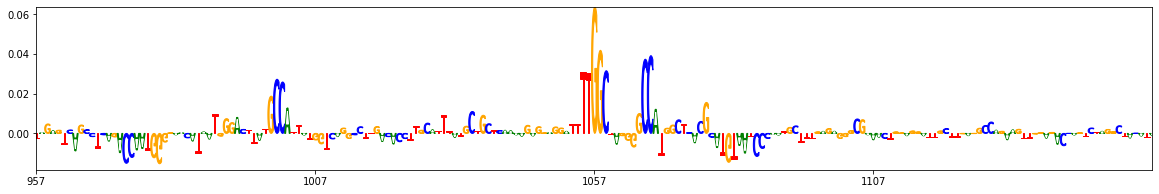

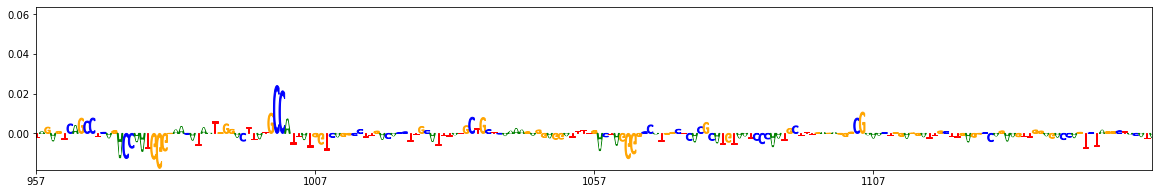

rsid chromo pos ref alt neg_log_pvalue abs_logfc jsd
rs58670143 chr20 49902343 G A 0.395449967428739 0.37849483 0.0702830657014169


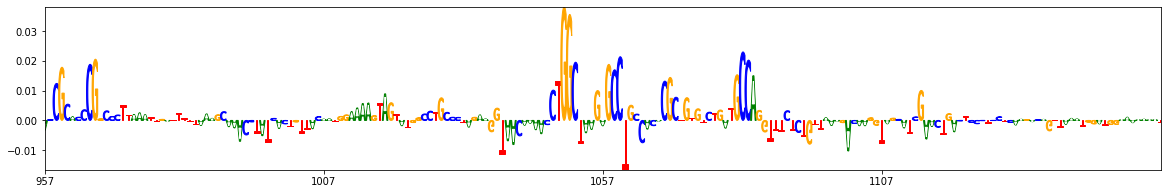

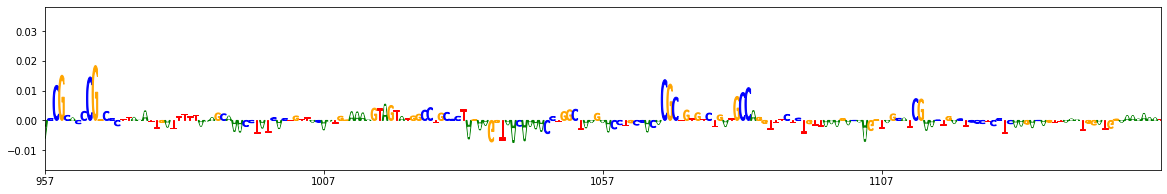

rsid chromo pos ref alt neg_log_pvalue abs_logfc jsd
rs148843574 chr20 49910320 C T 0.339229356472303 0.29182616 0.0430653310282554


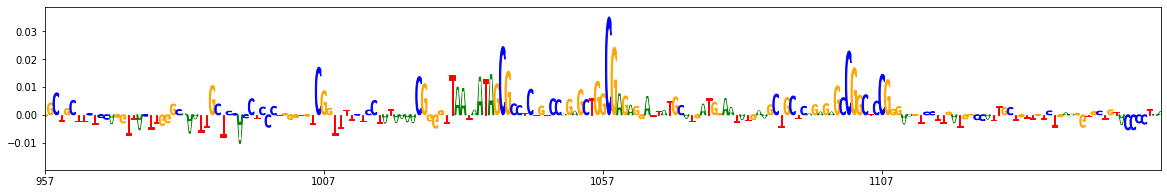

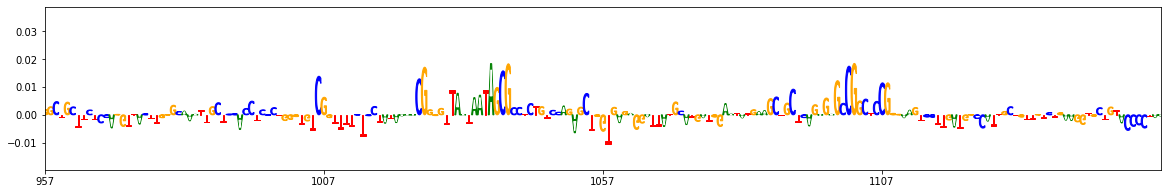

rsid chromo pos ref alt neg_log_pvalue abs_logfc jsd
rs74468049 chr20 50014216 G A 0.290899718448833 0.2859588 0.0508256314812594


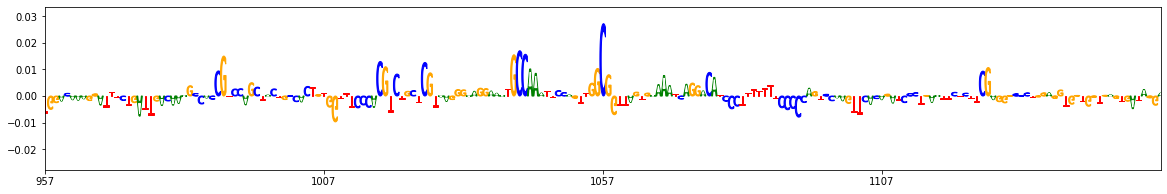

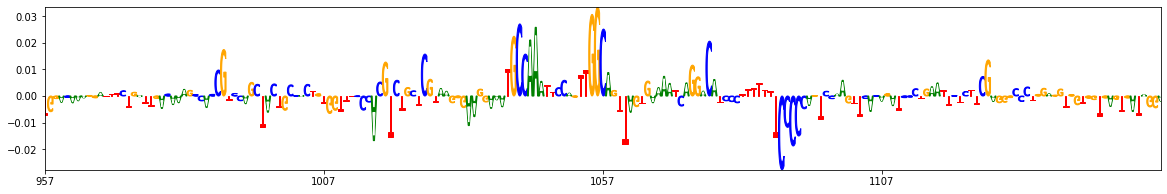

12
chr21 31647291 31750984


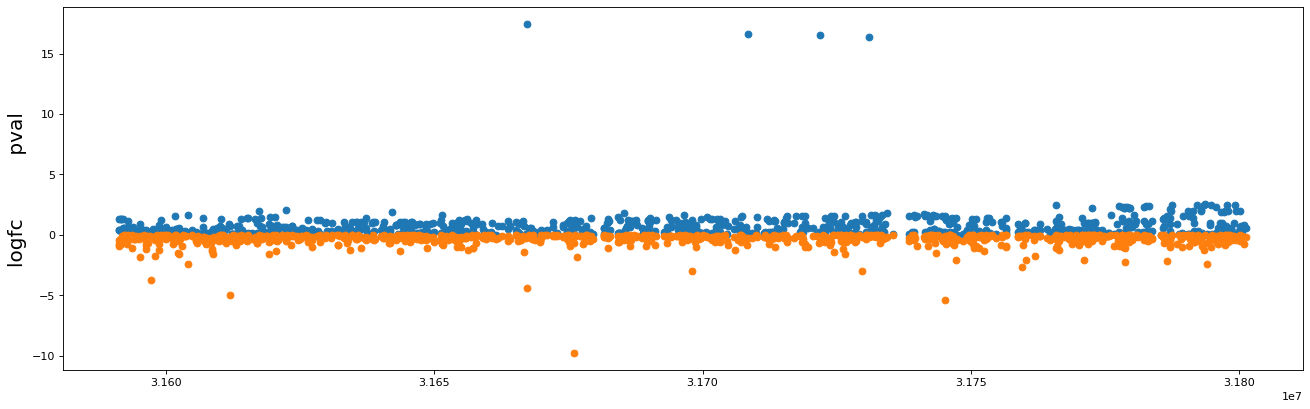

rsid chromo pos ref alt neg_log_pvalue abs_logfc jsd
rs73351374 chr21 31676003 T C 0.694863681056361 0.98202395 0.1408831690211172


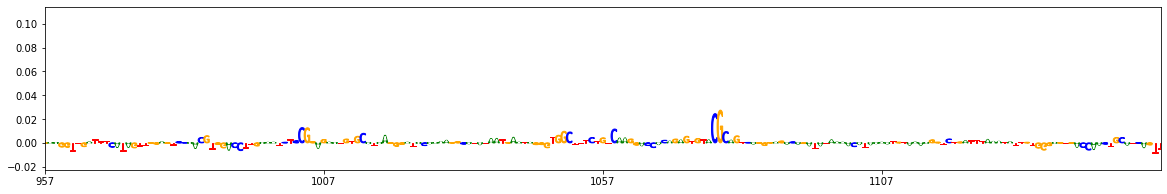

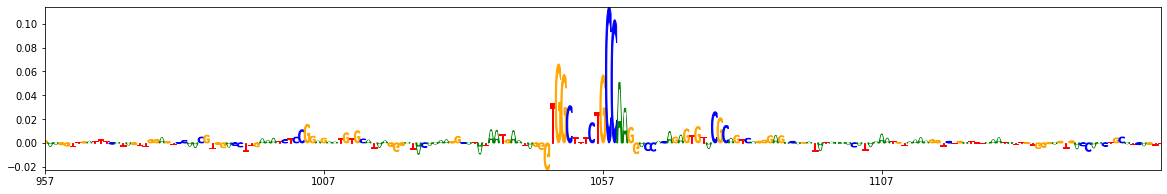

rsid chromo pos ref alt neg_log_pvalue abs_logfc jsd
rs111577012 chr21 31745289 G A 1.42957031833855 0.5364261 0.0683989172057579


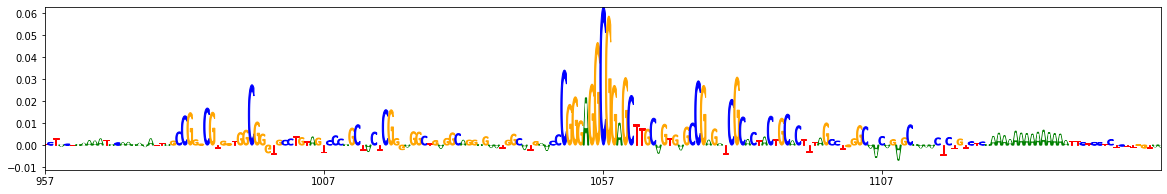

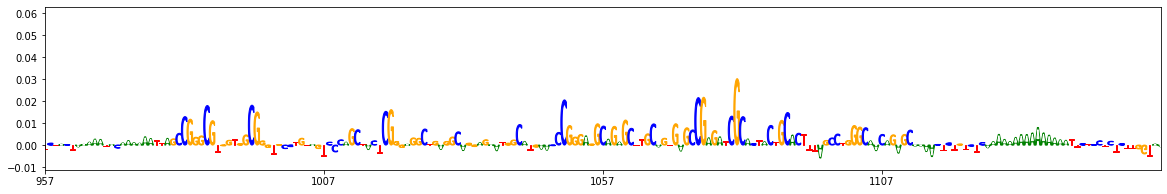

rsid chromo pos ref alt neg_log_pvalue abs_logfc jsd
rs80265967 chr21 31667290 A C 17.4508998299619 0.43710604 0.0771009383470584


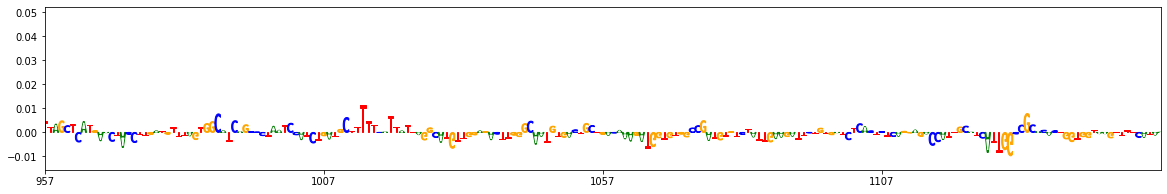

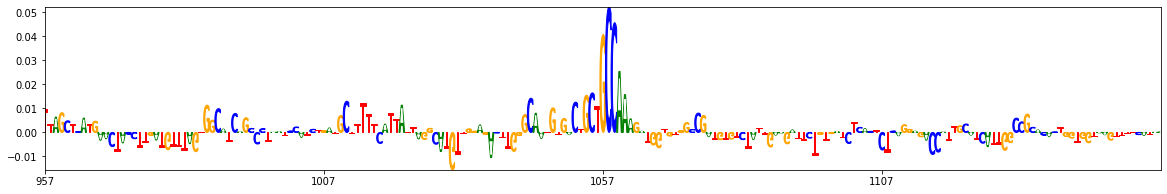

rsid chromo pos ref alt neg_log_pvalue abs_logfc jsd
rs13052593 chr21 31729686 T C 1.10591000653844 0.3016297 0.0666331034727896


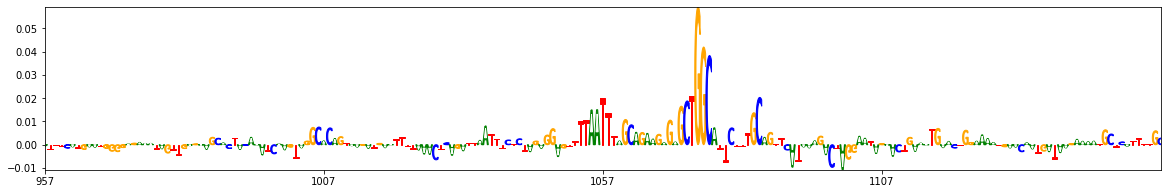

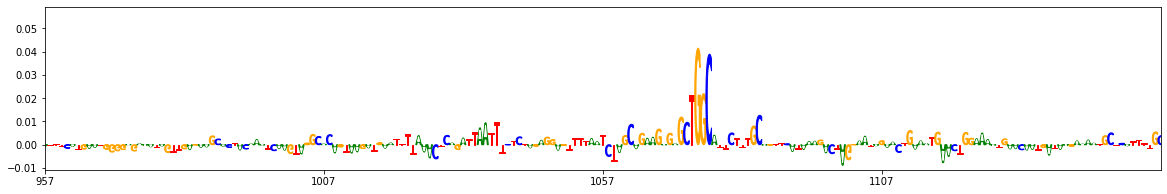

rsid chromo pos ref alt neg_log_pvalue abs_logfc jsd
rs73353407 chr21 31698024 C T 0.113283725883522 0.2986566 0.0535867686284379


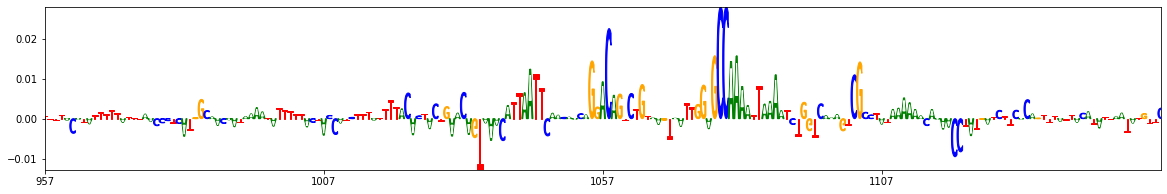

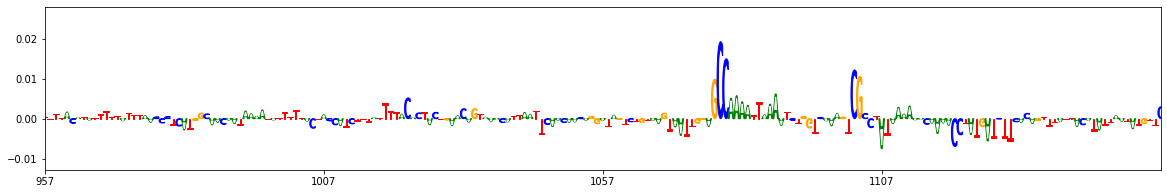

13
chr21 44313392 44346004


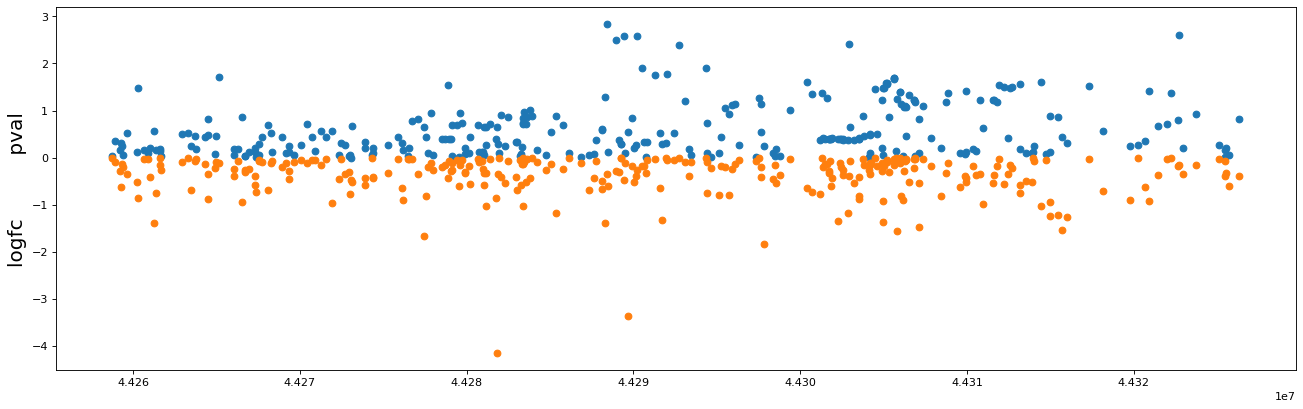

rsid chromo pos ref alt neg_log_pvalue abs_logfc jsd
rs138911415 chr21 44315711 G T 0.430041181903406 0.15474427 0.0197677155894993


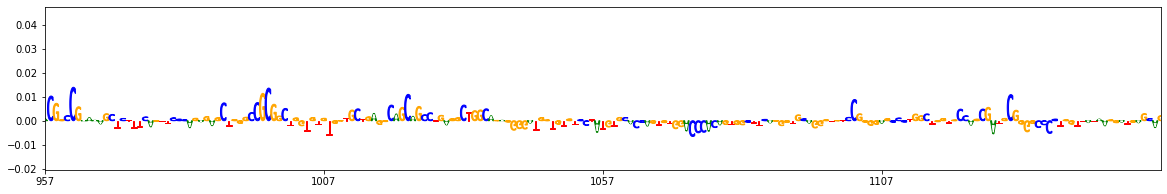

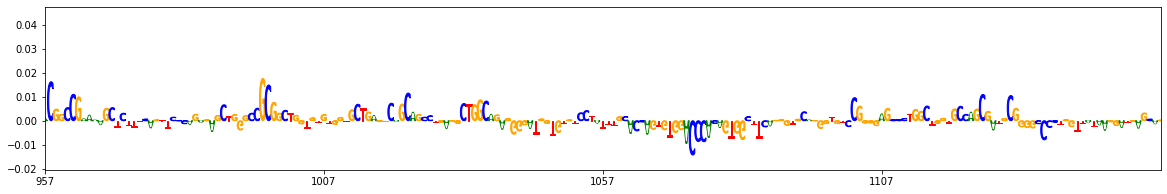

rsid chromo pos ref alt neg_log_pvalue abs_logfc jsd
rs3788121 chr21 44337017 A G 0.0540884831807266 0.1298062 0.0194937718942929


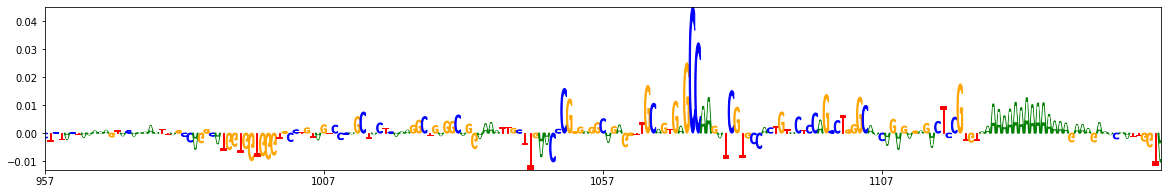

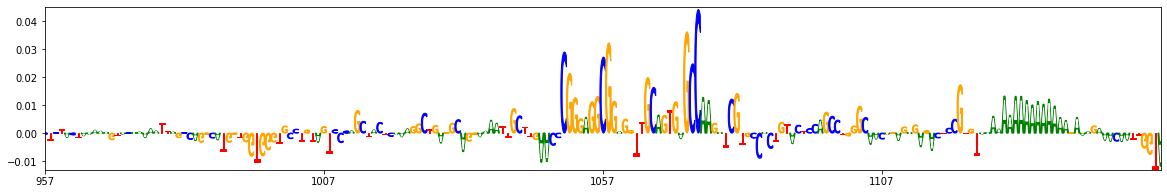

rsid chromo pos ref alt neg_log_pvalue abs_logfc jsd
rs548549330 chr21 44315977 G A 0.306448914404087 0.1271911 0.0423621525049097


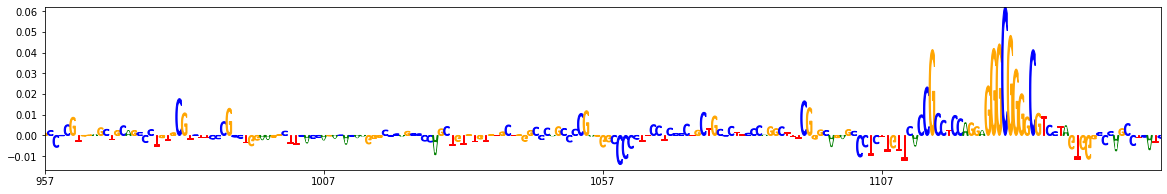

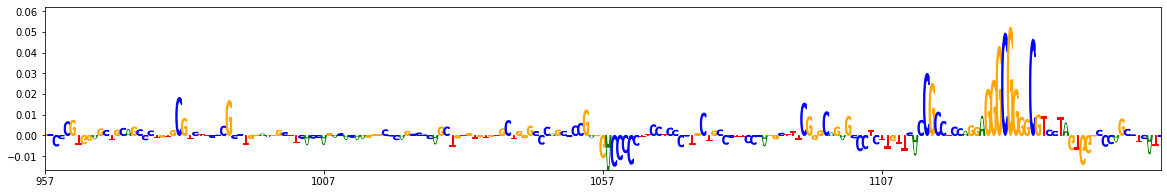

rsid chromo pos ref alt neg_log_pvalue abs_logfc jsd
rs59952509 chr21 44315480 A G 0.869988050328096 0.122459926 0.0298434238671912


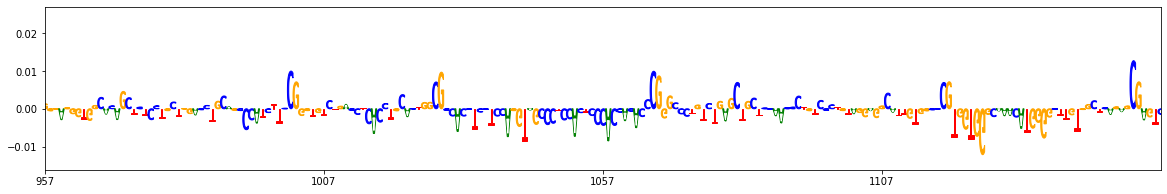

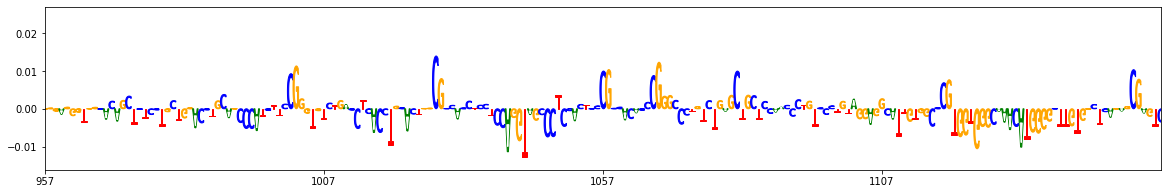

In [21]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
for cluster_number in range(1,14):
    print(cluster_number)
    coords = []
    pval = []
    logfc = []
    jsd_list = []
    cluster_variant_df = []
    
    cluster_df = all_filtered_gwas_results[all_filtered_gwas_results['cluster_num'] == cluster_number]
    cluster_real_start = min(cluster_df['start']) + 80000
    cluster_real_end = max(cluster_df['start']) - 80000
    
    print(cluster_df['chr'].values[0],cluster_real_start,cluster_real_end)
    for i, row in cluster_df.iterrows():
        coords += [row['start']]
        pval += [row['neg_log_pvalue']]
        logfc += [-row['abs_logfc']*10]
        jsd_list += [-row['jsd']*50]
        cluster_variant_df += [row]
    cluster_variant_df = pd.DataFrame(cluster_variant_df)

    coords = coords[120:-120]
    pval = pval[120:-120]
    logfc = logfc[120:-120]


    figure(figsize=(20, 6), dpi=80)
    plt.scatter(coords,pval)
    plt.scatter(coords,logfc)
    plt.ylabel("logfc          pval",fontsize=18)
    plt.show()

    cluster_sig_df = cluster_variant_df[(cluster_variant_df['start'] > cluster_real_start) & (cluster_variant_df['start'] < cluster_real_end)]
    cluster_sig_df = cluster_sig_df.sort_values('abs_logfc',ascending=False)[:5]
    
    plt.rcParams["figure.figsize"] = (20,3)
    for i, row in cluster_sig_df.iterrows():
        i = list(significant_variants_from_predictions[significant_variants_from_predictions['rsid'] == row['rsid']].index)
        if len(i) == 0:
            continue
        print('rsid','chromo', 'pos','ref','alt','neg_log_pvalue','abs_logfc','jsd')
        print(row['rsid'],row['chr'], row['start'], row['ref'],row['alt'],row['neg_log_pvalue'],row['abs_logfc'],row['jsd'])
        ymin = min([allele1_shap[i].min(),allele2_shap[i].min()])
        ymax = max([allele1_shap[i].max(),allele2_shap[i].max()])
        plot_shap(allele1_shap[i],allele1_sequences[i],xmin=1057-100,xmax=1057+100,ymin=ymin,ymax=ymax)
        plot_shap(allele2_shap[i],allele2_sequences[i],xmin=1057-100,xmax=1057+100,ymin=ymin,ymax=ymax)
        plt.show()
        